# Analyzing consumption patterns of large hotel in Downtown Manhattan

The dataset contains two distinct .csv files which contain information about the consumption patterns of an unidentifed large hotel in downtown Manhattan

> **`'energy_dataset.csv':`** Contains hourly information about the consumption patterns of a large hotel, broken down into various categories

> **`'weather_features.csv':`** Contains hourly information about the weather conditions (e.g. temperature, wind speed, humidity, rainfall, qualitative desctiption) of New York City

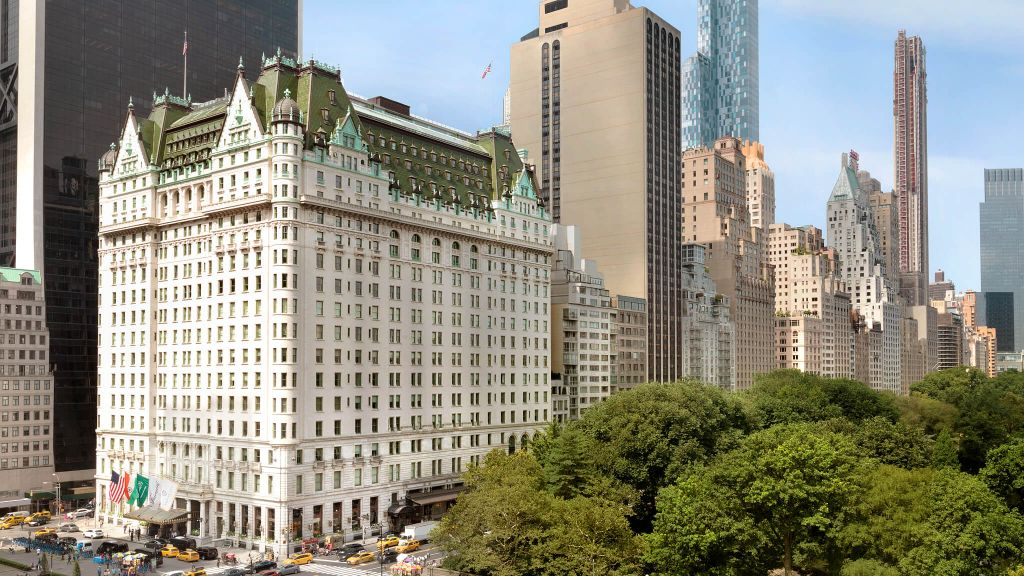

## Import Dependencies

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.constants import convert_temperature
import plotly.express as px

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## 1. Preliminary Clean Up & Merging

In [2]:
Hotel = pd.read_csv("/Users/chris/Desktop/App/Data/Industial_Consumption.csv")
Weather = pd.read_csv("/Users/chris/Desktop/App/Data/NYCWeather.csv")

In [3]:
Hotel.head()

Date/Time  Electricity:Facility [kW](Hourly)  \
0  01/01  01:00:00                         107.059673   
1  01/01  02:00:00                          87.077728   
2  01/01  03:00:00                         101.175043   
3  01/01  04:00:00                          84.829139   
4  01/01  05:00:00                          99.309535   

   Fans:Electricity [kW](Hourly)  Cooling:Electricity [kW](Hourly)  \
0                       2.745574                          2.392882   
1                       2.226381                          2.040240   
2                       2.782977                          2.532589   
3                       2.226381                          2.082326   
4                       2.782977                          2.568232   

   Heating:Electricity [kW](Hourly)  InteriorLights:Electricity [kW](Hourly)  \
0                         68.345865                                 2.680416   
1                         49.235754                                 2.680416   
2                         62.284125                                 2.680416   
3                         46.945079                                 2.680416   
4                         60.382974                                 2.680416   

   InteriorEquipment:Electricity [kW](Hourly)  
0                                   16.082496  
1                                   16.082496  
2                                   16.082496  
3                                   16.082496  
4                                   16.082496

In [4]:
def rename_hotel(data):
    
    naming_map = ['Date', 'Electricty Total (KwH)', 'Fans (KwH)', 'Cooling (KwH)', 'Heating (KwH)', 
                  'Lights (KwH)', 'Interior Equipment (KwH)']
    data.columns = data.columns[7:].tolist() + naming_map
    data = data.reset_index()  
    return data

Hotel = rename_hotel(Hotel)

In [5]:
Hotel.head()

index             Date  Electricty Total (KwH)  Fans (KwH)  Cooling (KwH)  \
0      0  01/01  01:00:00              107.059673    2.745574       2.392882   
1      1  01/01  02:00:00               87.077728    2.226381       2.040240   
2      2  01/01  03:00:00              101.175043    2.782977       2.532589   
3      3  01/01  04:00:00               84.829139    2.226381       2.082326   
4      4  01/01  05:00:00               99.309535    2.782977       2.568232   

   Heating (KwH)  Lights (KwH)  Interior Equipment (KwH)  
0      68.345865      2.680416                 16.082496  
1      49.235754      2.680416                 16.082496  
2      62.284125      2.680416                 16.082496  
3      46.945079      2.680416                 16.082496  
4      60.382974      2.680416                 16.082496

In [6]:
Weather.head()

# Date UT time  Temperature  Relative Humidity  Pressure  Wind speed  \
0  2004-01-01   01:00       276.06              88.64   1010.72        5.40   
1  2004-01-01   02:00       275.94              89.75   1010.06        5.71   
2  2004-01-01   03:00       275.80              90.72   1009.43        5.66   
3  2004-01-01   04:00       275.91              89.88   1009.11        6.13   
4  2004-01-01   05:00       275.83              90.32   1009.29        5.83   

   Wind direction  Rainfall  Snowfall  Snow depth  Short-wave irradiation  
0          222.59  0.000001  0.000000         0.0                     0.0  
1          226.64  0.000004  0.000004         0.0                     0.0  
2          237.02  0.000010  0.000134         0.0                     0.0  
3          252.98  0.000018  0.000199         0.0                     0.0  
4          266.92  0.000026  0.000000         0.0                     0.0

This fucntion converts the **date** columns to date-time format and deletes columns that we won't be using. It also creates an index column.

In [7]:
def clean_Weather(data):
    
    data['Temperature'] = ((data['Temperature'] - 273.15) * 9/5 + 32).round(2)
    data['UT time'] = data['UT time'].str.replace(r'\:00\b', '')
    data['UT time'] = data['UT time'].astype('float64')
    data = data.reset_index()  
    
    return data

Weather = clean_Weather(Weather)
Weather.head()

index      # Date  UT time  Temperature  Relative Humidity  Pressure  \
0      0  2004-01-01      1.0        37.24              88.64   1010.72   
1      1  2004-01-01      2.0        37.02              89.75   1010.06   
2      2  2004-01-01      3.0        36.77              90.72   1009.43   
3      3  2004-01-01      4.0        36.97              89.88   1009.11   
4      4  2004-01-01      5.0        36.82              90.32   1009.29   

   Wind speed  Wind direction  Rainfall  Snowfall  Snow depth  \
0        5.40          222.59  0.000001  0.000000         0.0   
1        5.71          226.64  0.000004  0.000004         0.0   
2        5.66          237.02  0.000010  0.000134         0.0   
3        6.13          252.98  0.000018  0.000199         0.0   
4        5.83          266.92  0.000026  0.000000         0.0   

   Short-wave irradiation  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0

This function merges the datasets

In [8]:
def merge(data1, data2):

    data = pd.merge(data1, data2, on= "index", how="left")
    del data['Date']
    data = data.rename(columns={"# Date": "Date"})
    data = data.rename(columns={"UT time": "Hour"})
    data['Date'] = data['Date'].astype('datetime64[ns]')
    del data['index']

    return data

Hotel = merge(Weather, Hotel)
Hotel.head()

Date  Hour  Temperature  Relative Humidity  Pressure  Wind speed  \
0 2004-01-01   1.0        37.24              88.64   1010.72        5.40   
1 2004-01-01   2.0        37.02              89.75   1010.06        5.71   
2 2004-01-01   3.0        36.77              90.72   1009.43        5.66   
3 2004-01-01   4.0        36.97              89.88   1009.11        6.13   
4 2004-01-01   5.0        36.82              90.32   1009.29        5.83   

   Wind direction  Rainfall  Snowfall  Snow depth  Short-wave irradiation  \
0          222.59  0.000001  0.000000         0.0                     0.0   
1          226.64  0.000004  0.000004         0.0                     0.0   
2          237.02  0.000010  0.000134         0.0                     0.0   
3          252.98  0.000018  0.000199         0.0                     0.0   
4          266.92  0.000026  0.000000         0.0                     0.0   

   Electricty Total (KwH)  Fans (KwH)  Cooling (KwH)  Heating (KwH)  \
0              107.059673    2.745574       2.392882      68.345865   
1               87.077728    2.226381       2.040240      49.235754   
2              101.175043    2.782977       2.532589      62.284125   
3               84.829139    2.226381       2.082326      46.945079   
4               99.309535    2.782977       2.568232      60.382974   

   Lights (KwH)  Interior Equipment (KwH)  
0      2.680416                 16.082496  
1      2.680416                 16.082496  
2      2.680416                 16.082496  
3      2.680416                 16.082496  
4      2.680416                 16.082496

## 2. Feature Engineering 

In [9]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
weekend = [0, 0, 0, 0, 0, 1, 1]
month_to_season = dict(zip(range(1,13), seasons))
day_to_weekend = dict(zip(range(0,7), weekend))

In [10]:
Hotel.head()

Date  Hour  Temperature  Relative Humidity  Pressure  Wind speed  \
0 2004-01-01   1.0        37.24              88.64   1010.72        5.40   
1 2004-01-01   2.0        37.02              89.75   1010.06        5.71   
2 2004-01-01   3.0        36.77              90.72   1009.43        5.66   
3 2004-01-01   4.0        36.97              89.88   1009.11        6.13   
4 2004-01-01   5.0        36.82              90.32   1009.29        5.83   

   Wind direction  Rainfall  Snowfall  Snow depth  Short-wave irradiation  \
0          222.59  0.000001  0.000000         0.0                     0.0   
1          226.64  0.000004  0.000004         0.0                     0.0   
2          237.02  0.000010  0.000134         0.0                     0.0   
3          252.98  0.000018  0.000199         0.0                     0.0   
4          266.92  0.000026  0.000000         0.0                     0.0   

   Electricty Total (KwH)  Fans (KwH)  Cooling (KwH)  Heating (KwH)  \
0              107.059673    2.745574       2.392882      68.345865   
1               87.077728    2.226381       2.040240      49.235754   
2              101.175043    2.782977       2.532589      62.284125   
3               84.829139    2.226381       2.082326      46.945079   
4               99.309535    2.782977       2.568232      60.382974   

   Lights (KwH)  Interior Equipment (KwH)  
0      2.680416                 16.082496  
1      2.680416                 16.082496  
2      2.680416                 16.082496  
3      2.680416                 16.082496  
4      2.680416                 16.082496

In [11]:
def Holidays(data):
    
    Holiday_List = ['1/1/04', '01/19/04', '02/19/04', '05/31/04', '07/04/04', '09/06/04', 
                    '10/11/04', '11/11/04', '11/25/04', '12/25/04']

    data['Check_Holiday'] = pd.to_datetime(data["Date"]).dt.strftime('%d/%m/%y')
    data['Check_Holiday'] = data['Check_Holiday'].isin(Holiday_List)
    data['Holiday'] = data['Check_Holiday']
    data['Holiday'] = data['Holiday'].astype('float64')
    del data['Check_Holiday']
    
    return data

Hotel = Holidays(Hotel)

In [12]:
def Temporal(data):
    
    data['Hour'] = data['Hour'].astype('float64')

    data['Day'] = data['Date'].dt.dayofweek
    data['Day'] = data['Day'].astype('float64')

    data['Month'] = data['Date'].dt.month
    data['Month'] = data['Month'].astype('float64')
    
    data = data.round(2)
    data['Weekend'] = data.Day.map(day_to_weekend)
    data['Season'] = data.Month.map(month_to_season)
    
    return data
    
Hotel = Temporal(Hotel)

In [13]:
def Working_Data(data):
    
    data['Working_Hour'] = 0
    for i in range(len(data)):
        data.loc[(data['Hour'] >= 8.0) & (data['Hour'] <= 17.0),'Working_Hour'] = 1
    
    return data
    
Hotel = Working_Data(Hotel)

In [14]:
Hotel.head()

Date  Hour  Temperature  Relative Humidity  Pressure  Wind speed  \
0 2004-01-01   1.0        37.24              88.64   1010.72        5.40   
1 2004-01-01   2.0        37.02              89.75   1010.06        5.71   
2 2004-01-01   3.0        36.77              90.72   1009.43        5.66   
3 2004-01-01   4.0        36.97              89.88   1009.11        6.13   
4 2004-01-01   5.0        36.82              90.32   1009.29        5.83   

   Wind direction  Rainfall  Snowfall  Snow depth  Short-wave irradiation  \
0          222.59       0.0       0.0         0.0                     0.0   
1          226.64       0.0       0.0         0.0                     0.0   
2          237.02       0.0       0.0         0.0                     0.0   
3          252.98       0.0       0.0         0.0                     0.0   
4          266.92       0.0       0.0         0.0                     0.0   

   Electricty Total (KwH)  Fans (KwH)  Cooling (KwH)  Heating (KwH)  \
0                  107.06        2.75           2.39          68.35   
1                   87.08        2.23           2.04          49.24   
2                  101.18        2.78           2.53          62.28   
3                   84.83        2.23           2.08          46.95   
4                   99.31        2.78           2.57          60.38   

   Lights (KwH)  Interior Equipment (KwH)  Holiday  Day  Month  Weekend  \
0          2.68                     16.08      0.0  3.0    1.0        0   
1          2.68                     16.08      0.0  3.0    1.0        0   
2          2.68                     16.08      0.0  3.0    1.0        0   
3          2.68                     16.08      0.0  3.0    1.0        0   
4          2.68                     16.08      0.0  3.0    1.0        0   

   Season  Working_Hour  
0       1             0  
1       1             0  
2       1             0  
3       1             0  
4       1             0

This converts the final dataset into a csv file

In [15]:
Hotel.to_csv(r'/Users/chris/Desktop/App/DataHotel_Processed.csv', index = False)

## 3. Visualizations

In [16]:
Hotel.head()

Date  Hour  Temperature  Relative Humidity  Pressure  Wind speed  \
0 2004-01-01   1.0        37.24              88.64   1010.72        5.40   
1 2004-01-01   2.0        37.02              89.75   1010.06        5.71   
2 2004-01-01   3.0        36.77              90.72   1009.43        5.66   
3 2004-01-01   4.0        36.97              89.88   1009.11        6.13   
4 2004-01-01   5.0        36.82              90.32   1009.29        5.83   

   Wind direction  Rainfall  Snowfall  Snow depth  Short-wave irradiation  \
0          222.59       0.0       0.0         0.0                     0.0   
1          226.64       0.0       0.0         0.0                     0.0   
2          237.02       0.0       0.0         0.0                     0.0   
3          252.98       0.0       0.0         0.0                     0.0   
4          266.92       0.0       0.0         0.0                     0.0   

   Electricty Total (KwH)  Fans (KwH)  Cooling (KwH)  Heating (KwH)  \
0                  107.06        2.75           2.39          68.35   
1                   87.08        2.23           2.04          49.24   
2                  101.18        2.78           2.53          62.28   
3                   84.83        2.23           2.08          46.95   
4                   99.31        2.78           2.57          60.38   

   Lights (KwH)  Interior Equipment (KwH)  Holiday  Day  Month  Weekend  \
0          2.68                     16.08      0.0  3.0    1.0        0   
1          2.68                     16.08      0.0  3.0    1.0        0   
2          2.68                     16.08      0.0  3.0    1.0        0   
3          2.68                     16.08      0.0  3.0    1.0        0   
4          2.68                     16.08      0.0  3.0    1.0        0   

   Season  Working_Hour  
0       1             0  
1       1             0  
2       1             0  
3       1             0  
4       1             0

In [17]:
Hotel.describe().round(2)

Hour  Temperature  Relative Humidity  Pressure  Wind speed  \
count  8760.00      8760.00            8760.00   8760.00     8760.00   
mean     12.50        51.45              79.99   1008.71        3.62   
std       6.92        18.34              14.44      7.67        1.68   
min       1.00         0.90              38.61    979.50        0.03   
25%       6.75        37.02              70.51   1003.68        2.46   
50%      12.50        52.63              83.26   1009.21        3.36   
75%      18.25        66.96              92.06   1013.88        4.57   
max      24.00        86.14             109.51   1031.23       11.09   

       Wind direction  Rainfall  Snowfall  Snow depth  Short-wave irradiation  \
count         8760.00   8760.00   8760.00     8760.00                 8760.00   
mean           203.70      0.15      0.02        0.01                  180.47   
std            103.13      0.55      0.13        0.02                  259.57   
min              0.02      0.00      0.00        0.00                    0.00   
25%            125.31      0.00      0.00        0.00                    0.00   
50%            216.39      0.00      0.00        0.00                    7.22   
75%            294.64      0.05      0.00        0.00                  313.86   
max            359.99     10.19      3.00        0.12                 1011.55   

       Electricty Total (KwH)  Fans (KwH)  Cooling (KwH)  Heating (KwH)  \
count                 8760.00     8760.00        8760.00        8760.00   
mean                    85.94        2.15          11.06          12.31   
std                     53.11        1.94          17.37          25.39   
min                     18.77        0.00           0.00           0.00   
25%                     38.94        0.00           0.00           0.00   
50%                     77.93        3.34           0.22           0.00   
75%                    134.88        3.36          17.88          11.88   
max                    312.93        8.72          87.97         263.23   

       Lights (KwH)  Interior Equipment (KwH)  Holiday      Day    Month  \
count       8760.00                   8760.00  8760.00  8760.00  8760.00   
mean          19.22                     33.82     0.01     2.99     6.53   
std           19.22                     19.08     0.10     1.99     3.45   
min            2.68                     16.08     0.00     0.00     1.00   
25%            2.68                     20.05     0.00     1.00     4.00   
50%            5.36                     21.44     0.00     3.00     7.00   
75%           48.25                     60.13     0.00     5.00    10.00   
max           48.25                     70.40     1.00     6.00    12.00   

       Weekend   Season  Working_Hour  
count  8760.00  8760.00       8760.00  
mean      0.28     2.50          0.42  
std       0.45     1.11          0.49  
min       0.00     1.00          0.00  
25%       0.00     2.00          0.00  
50%       0.00     3.00          0.00  
75%       1.00     3.00          1.00  
max       1.00     4.00          1.00

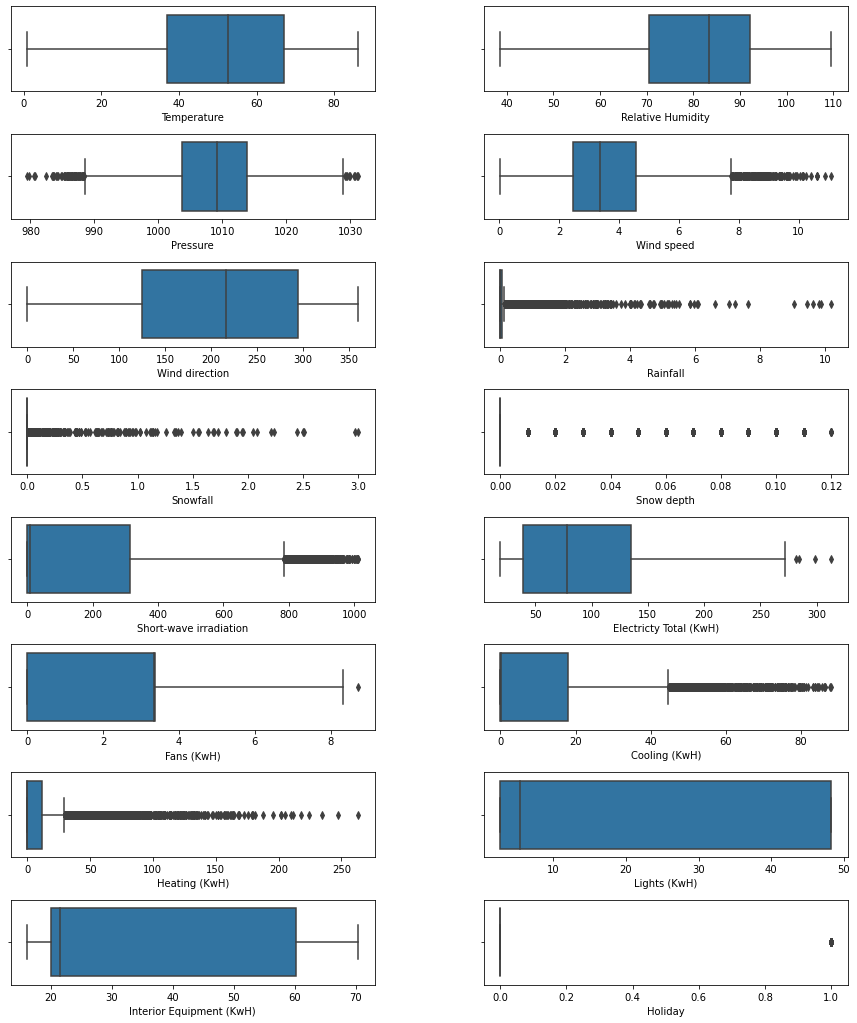

In [18]:
fig, axes = plt.subplots(ncols = 2, nrows = 8, figsize = (15,18))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

for ax, col in zip(axes.flatten(), Hotel.columns[2:]):
    sns.boxplot(x = Hotel[col], ax = ax)

In [19]:
def plot_series(df=None, column=None, series=pd.Series([]), label=None, ylabel=None, title=None, start=0, end=None):
  
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    
    if column:
        ax.plot(df['Date'], df[column][start:end],  label=label)
        ax.set_ylabel(ylabel, fontsize=16)
        
    if series.any():
        ax.plot(df['Date'][start:end], series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
        
    if label:
        ax.legend(fontsize=16)
        
    if title:
        ax.set_title(title, fontsize=24)
        
    ax.grid(True)
    return ax

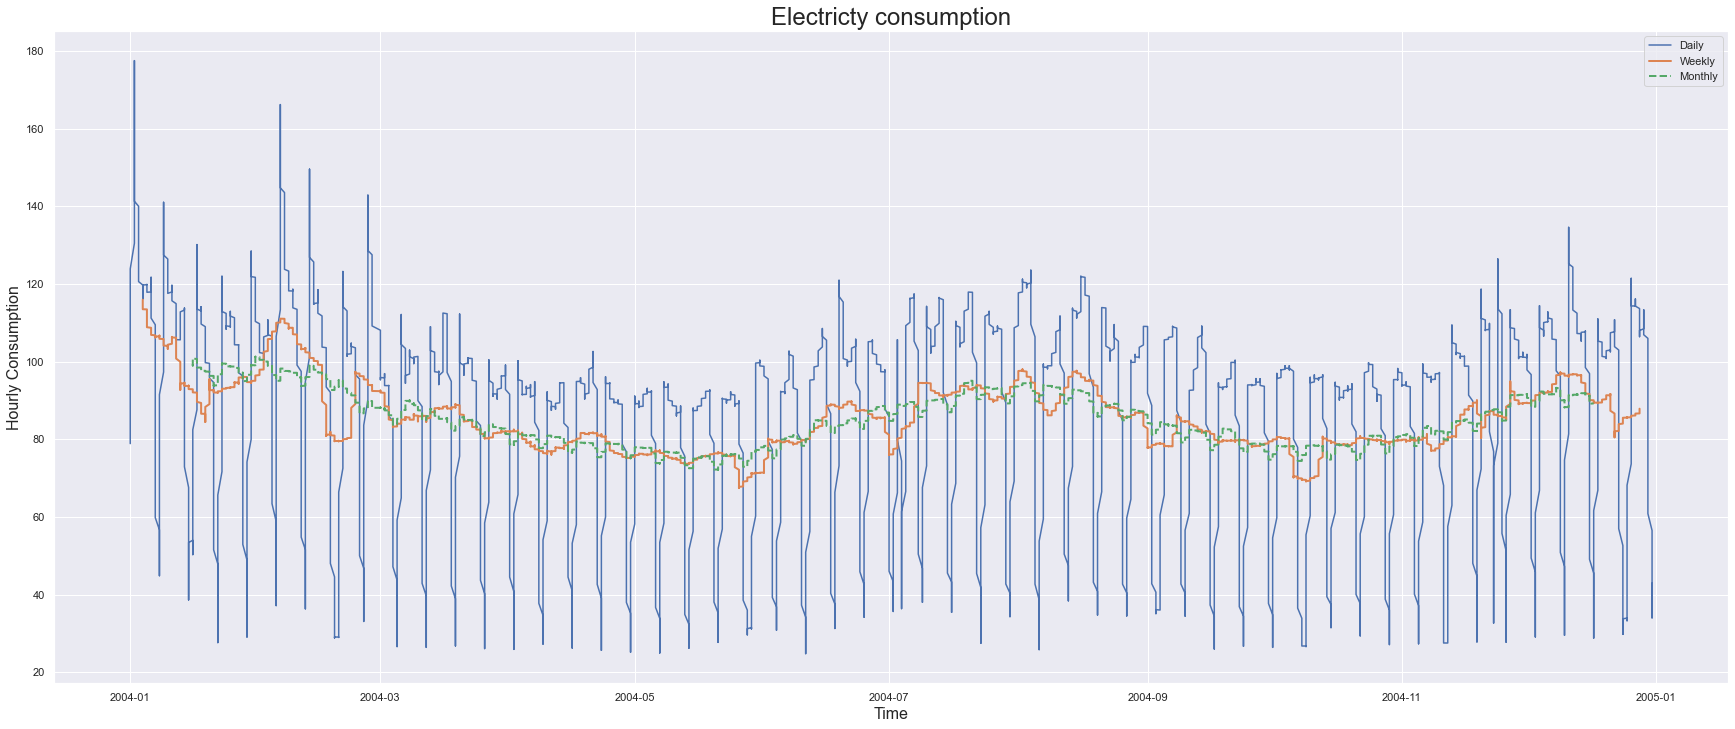

In [20]:
rolling_daily = Hotel['Electricty Total (KwH)'].rolling(24, center = True).mean()
rolling_weekly = Hotel['Electricty Total (KwH)'].rolling(24*7, center = True).mean()
rolling_monthly = Hotel['Electricty Total (KwH)'].rolling(24*30, center = True).mean()

ax = plot_series(Hotel, series = rolling_daily, ylabel = 'Hourly Consumption', label='Daily', title = 'Electricty consumption')
ax.plot(Hotel['Date'], rolling_weekly, linestyle='-', linewidth = 2, label='Weekly')
ax.plot(Hotel['Date'], rolling_monthly, linestyle='--', linewidth = 2, label='Monthly')
ax.legend()

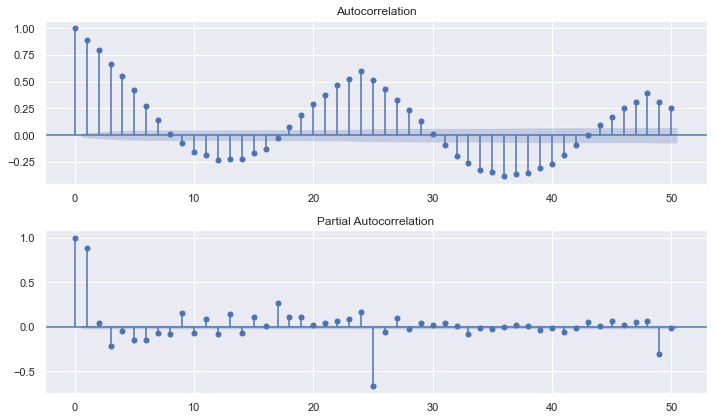

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(Hotel['Electricty Total (KwH)'], lags=50, ax=ax1)
plot_pacf(Hotel['Electricty Total (KwH)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [22]:
Fnas_agg = Hotel.groupby(['Month'], as_index=False, sort=False)['Fans (KwH)'].sum()
Cooling_agg = Hotel.groupby(['Month'], as_index=False, sort=False)['Cooling (KwH)'].sum()
Heating_agg = Hotel.groupby(['Month'], as_index=False, sort=False)['Heating (KwH)'].sum()
Lights_agg = Hotel.groupby(['Month'], as_index=False, sort=False)['Lights (KwH)'].sum()
Interior_agg = Hotel.groupby(['Month'], as_index=False, sort=False)['Interior Equipment (KwH)'].sum()

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Fans(KwH))', x = Fnas_agg['Month'], y=Fnas_agg['Fans (KwH)']),
    go.Bar(name='Cooling(KwH))', x = Cooling_agg['Month'], y=Cooling_agg['Cooling (KwH)']),
    go.Bar(name='Heating(KwH))', x = Heating_agg['Month'], y=Heating_agg['Heating (KwH)']),
    go.Bar(name='Lights(KwH))', x = Lights_agg['Month'], y=Lights_agg['Lights (KwH)']),
    go.Bar(name='Interior Equipment(KwH))', x = Interior_agg['Month'], y=Interior_agg['Interior Equipment (KwH)'])
])

fig.update_layout(barmode='stack')
fig.show()

In [23]:
Consumption = Hotel[['Fans (KwH)', 'Cooling (KwH)', 'Heating (KwH)', 'Lights (KwH)', 'Interior Equipment (KwH)']].copy()

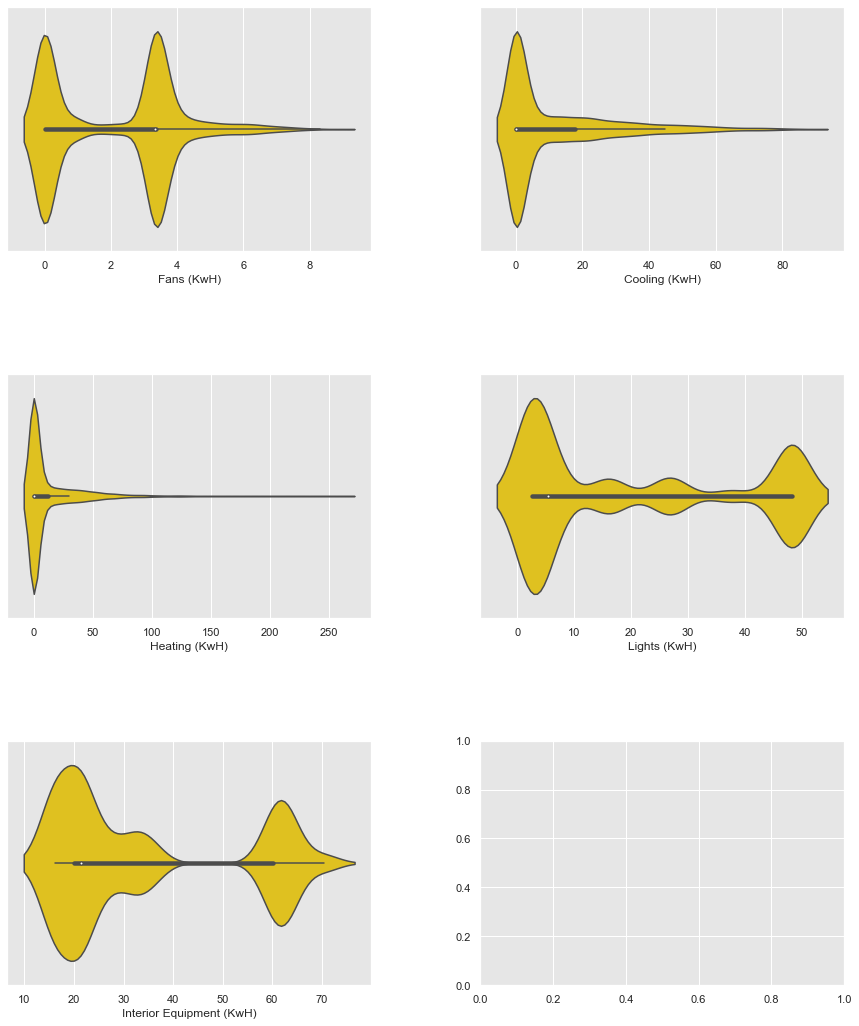

In [24]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (15,18))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

for ax, col in zip(axes.flatten(), Consumption.columns):
    sns.violinplot(x = Consumption[col], ax = ax, color = 'Gold',)

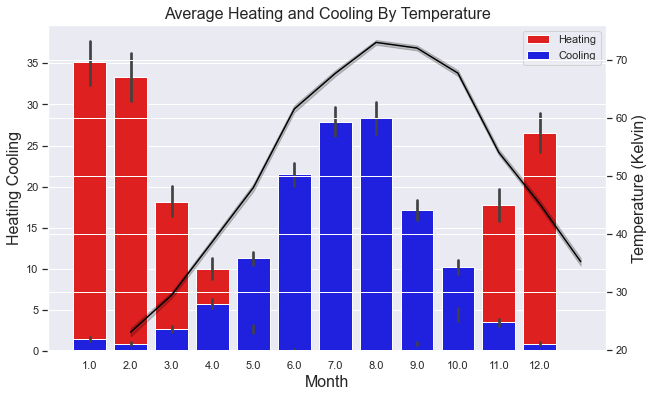

In [25]:
plt.rcParams['figure.figsize'] =(16,9)
plt.style.use('ggplot')
sns.set()

data = {'Month': Hotel['Month'], 'Avg_Temp': Hotel['Temperature'], 'Heating': Hotel['Heating (KwH)'], 'Cooling': Hotel['Cooling (KwH)']}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Average Heating and Cooling By Temperature', fontsize=16)
ax1.tick_params(axis='y')

ax2 = sns.barplot(x='Month', y='Heating', data = df, color = 'Red', label='Heating')
ax2 = sns.barplot(x='Month', y='Cooling', data = df, color = 'Blue', label='Cooling')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='Month', y='Avg_Temp', data = df, sort=False, color= 'Black')

ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Heating Cooling', fontsize=16)

ax2.tick_params(axis='y')
ax2.set_ylabel('Temperature (Kelvin)', fontsize=16)

ax1.legend()
plt.show()

## 4. Linear Regression

### Daily

In [26]:
Daily = Hotel.groupby(np.arange(len(df))//24).mean()
del Daily['Hour']
Daily.head()

Temperature  Relative Humidity     Pressure  Wind speed  Wind direction  \
0    36.635417          82.240000  1014.544167    4.351250      287.195833   
1    39.072083          84.192083  1013.948750    2.354167      208.806250   
2    44.232917          93.571667  1007.315000    2.582500      197.126250   
3    45.869583          93.350417  1004.243750    2.865833      170.373333   
4    37.180833          93.744167  1002.770417    3.532500       66.755417   

   Rainfall  Snowfall  Snow depth  Short-wave irradiation  \
0  0.000000  0.000000    0.000000               99.962083   
1  0.122917  0.027917    0.000000               55.240833   
2  0.074167  0.000000    0.000000               56.802500   
3  0.390000  0.000000    0.000000               39.391667   
4  0.744167  0.366667    0.013333               16.880000   

   Electricty Total (KwH)  Fans (KwH)  Cooling (KwH)  Heating (KwH)  \
0               78.859583    2.412083       2.262500      46.264583   
1              172.342500    2.852917       0.725000      93.702917   
2              125.348750    2.446667       3.273750      44.566250   
3              117.118750    2.302083       0.472083      39.281667   
4              118.794167    2.438333       0.418750      40.875833   

   Lights (KwH)  Interior Equipment (KwH)  Holiday  Day  Month  Weekend  \
0      2.680000                  16.08000      0.0  3.0    1.0      0.0   
1     25.240833                  40.66125      0.0  4.0    1.0      0.0   
2     25.240833                  40.66125      0.0  5.0    1.0      1.0   
3     25.240833                  40.66125      0.0  6.0    1.0      1.0   
4     25.240833                  40.66125      0.0  0.0    1.0      0.0   

   Season  Working_Hour  
0     1.0      0.416667  
1     1.0      0.416667  
2     1.0      0.416667  
3     1.0      0.416667  
4     1.0      0.416667

In [27]:
df = Daily[['Weekend', 'Season', 'Day', 'Temperature', 'Electricty Total (KwH)']]

trainSet = df[0:255]
testSet = df[255:365]

XX_elect_train = trainSet.drop('Electricty Total (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Electricty Total (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Electricty Total (KwH)']
YY_elect_test = testSet['Electricty Total (KwH)']

trainSet.head()

Weekend  Season  Day  Temperature  Electricty Total (KwH)
0      0.0     1.0  3.0    36.635417               78.859583
1      0.0     1.0  4.0    39.072083              172.342500
2      1.0     1.0  5.0    44.232917              125.348750
3      1.0     1.0  6.0    45.869583              117.118750
4      0.0     1.0  0.0    37.180833              118.794167

In [28]:
correlations = Daily.corr(method='pearson')
correlations_price = abs(correlations['Electricty Total (KwH)'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Electricty Total (KwH)      1.000000
Lights (KwH)                0.919649
Interior Equipment (KwH)    0.912127
Fans (KwH)                  0.865654
Heating (KwH)               0.472925
Cooling (KwH)               0.309278
Weekend                     0.308296
Season                      0.132521
Day                         0.130655
Temperature                 0.118343
Snow depth                  0.117700
Month                       0.084514
Snowfall                    0.083328
Wind speed                  0.080702
Short-wave irradiation      0.072672


In [29]:
from sklearn.linear_model import LinearRegression

lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  0.5909941185389427
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0        Weekend                69.163413
1         Season                -2.611162
2            Day               -14.027100
3    Temperature                -0.075538

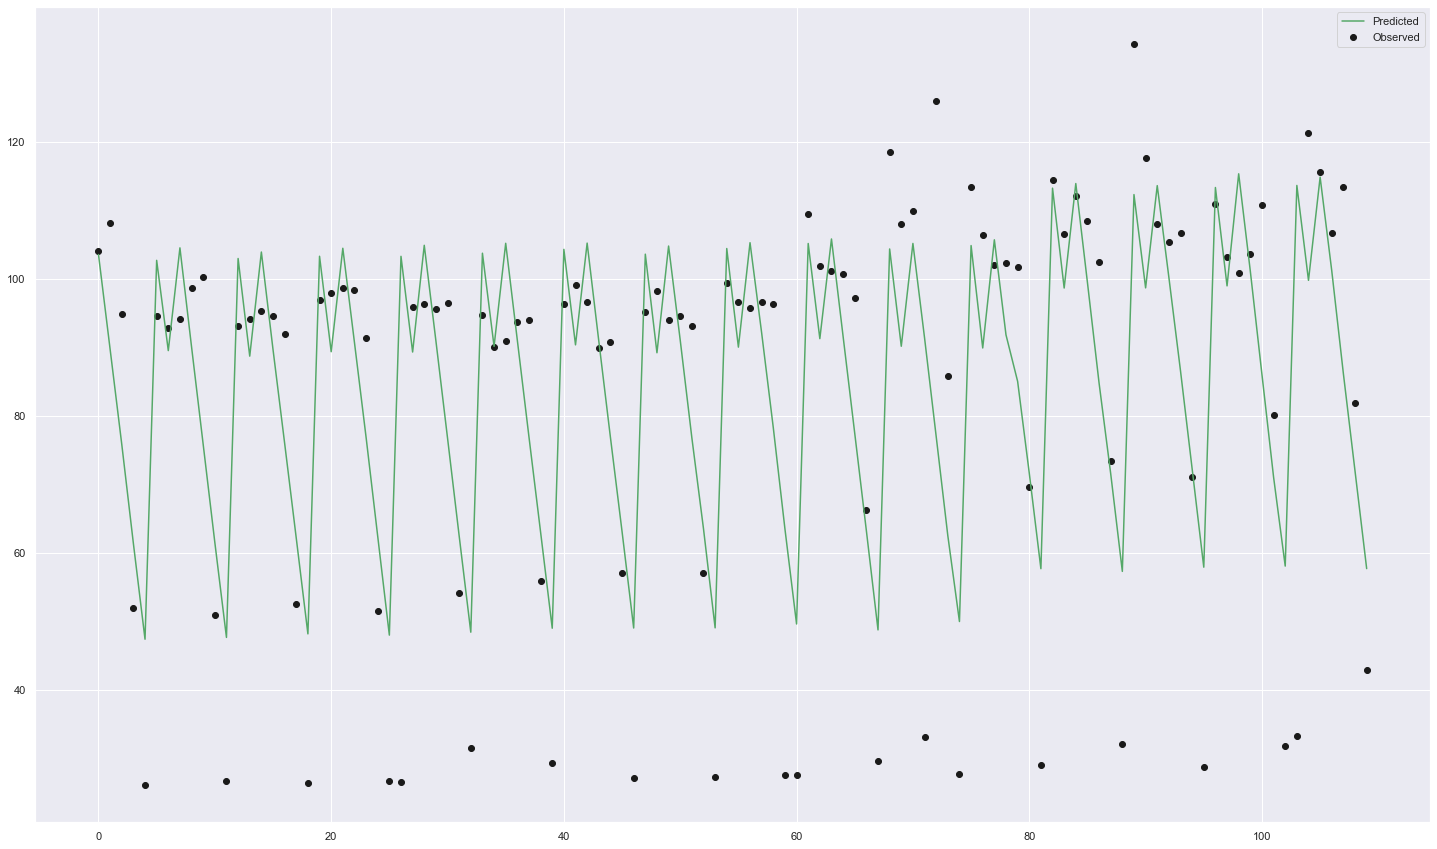

In [30]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='g')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec.: $Y_i$ vs $\\hat{Y}_i$')

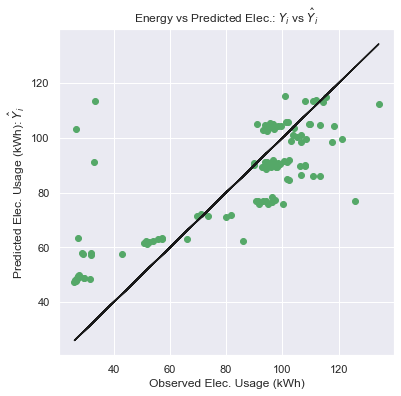

In [31]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='g')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$")
plt.title("Energy vs Predicted Elec.: $Y_i$ vs $\hat{Y}_i$")

In [32]:
correlations = Daily.corr(method='pearson')
correlations_price = abs(correlations['Heating (KwH)'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Heating (KwH)               1.000000
Temperature                 0.704619
Season                      0.567381
Cooling (KwH)               0.561894
Short-wave irradiation      0.526866
Electricty Total (KwH)      0.472925
Snow depth                  0.410168
Wind speed                  0.375656
Month                       0.281326
Snowfall                    0.249809
Lights (KwH)                0.209764
Interior Equipment (KwH)    0.199267
Relative Humidity           0.168470
Wind direction              0.122033
Weekend                     0.091980
Pressure                    0.083681
Fans (KwH)                  0.077054
Holiday                     0.062096


In [33]:
df = Daily[['Temperature', 'Season', 'Short-wave irradiation', 'Snow depth', 'Wind speed', 'Heating (KwH)']]

trainSet = df[0:255]
testSet = df[255:365]

XX_elect_train = trainSet.drop('Heating (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Heating (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Heating (KwH)']
YY_elect_test = testSet['Heating (KwH)']

trainSet.head()

Temperature  Season  Short-wave irradiation  Snow depth  Wind speed  \
0    36.635417     1.0               99.962083    0.000000    4.351250   
1    39.072083     1.0               55.240833    0.000000    2.354167   
2    44.232917     1.0               56.802500    0.000000    2.582500   
3    45.869583     1.0               39.391667    0.000000    2.865833   
4    37.180833     1.0               16.880000    0.013333    3.532500   

   Heating (KwH)  
0      46.264583  
1      93.702917  
2      44.566250  
3      39.281667  
4      40.875833

In [34]:
lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  0.2276188403838184
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0             Temperature                -0.296418
1                  Season                -6.517037
2  Short-wave irradiation                -0.027668
3              Snow depth                28.903124
4              Wind speed                -0.084728

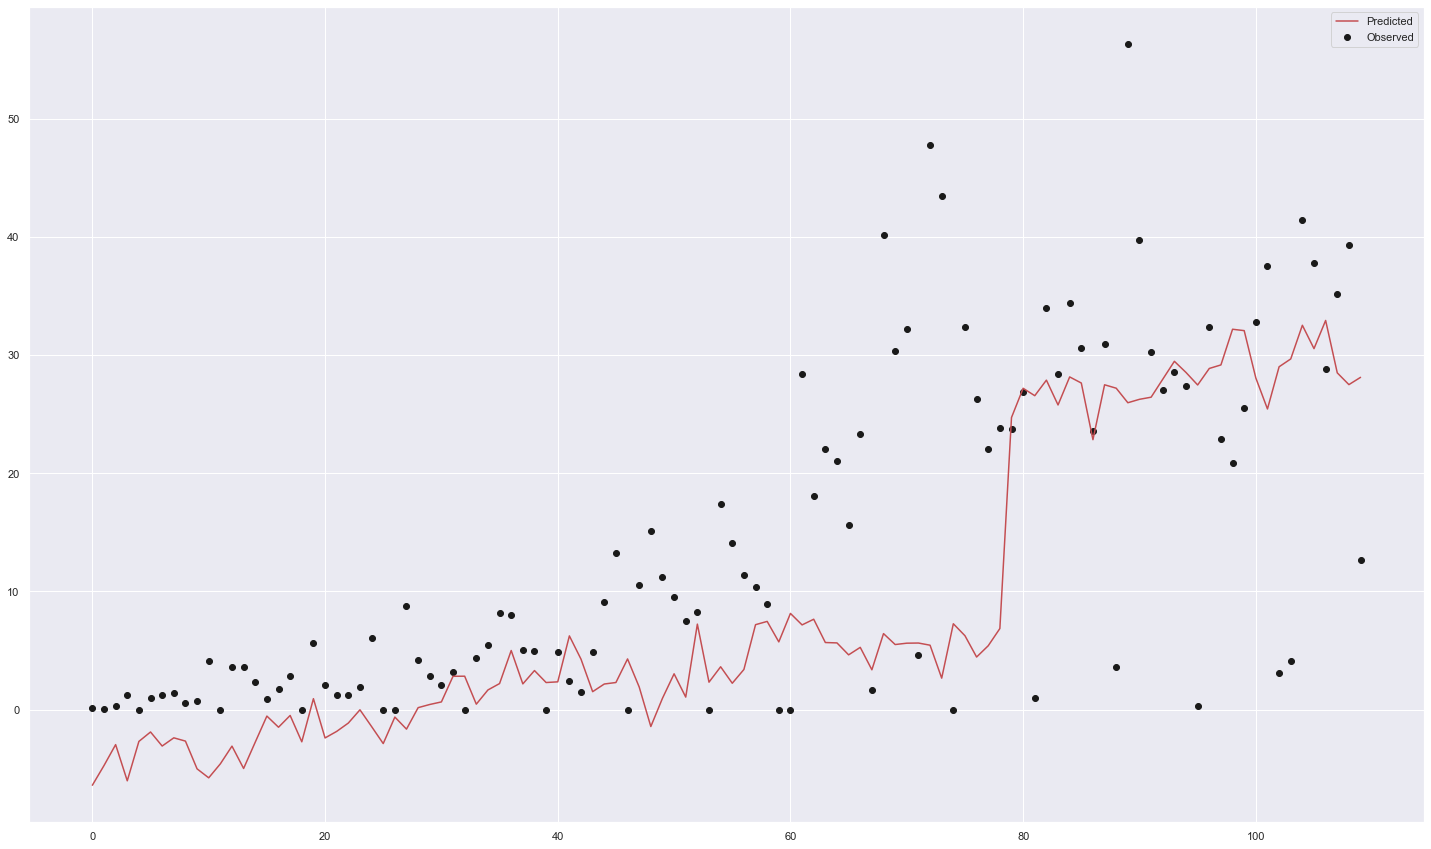

In [35]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='r')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec.: $Y_i$ vs $\\hat{Y}_i$')

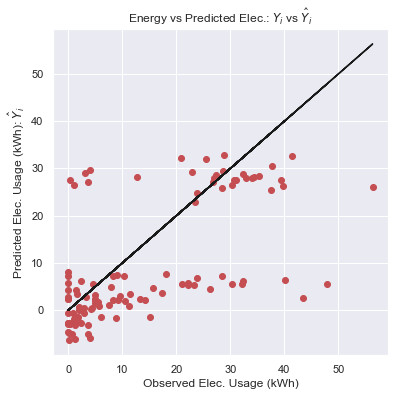

In [36]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='r')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$")
plt.title("Energy vs Predicted Elec.: $Y_i$ vs $\hat{Y}_i$")

In [37]:
correlations = Daily.corr(method='pearson')
correlations_price = abs(correlations['Cooling (KwH)'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Cooling (KwH)               1.000000
Temperature                 0.727218
Fans (KwH)                  0.669410
Heating (KwH)               0.561894
Short-wave irradiation      0.529882
Season                      0.438161
Wind speed                  0.375703
Lights (KwH)                0.340499
Interior Equipment (KwH)    0.336383
Electricty Total (KwH)      0.309278
Snow depth                  0.283373
Month                       0.181478
Relative Humidity           0.178908
Snowfall                    0.164650
Pressure                    0.131234
Day                         0.104083
Wind direction              0.084567
Weekend                     0.080065


In [38]:
df = Daily[['Temperature', 'Short-wave irradiation', 'Season', 'Wind speed', 'Cooling (KwH)']]

trainSet = df[0:255]
testSet = df[255:365]

XX_elect_train = trainSet.drop('Cooling (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Cooling (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Cooling (KwH)']
YY_elect_test = testSet['Cooling (KwH)']

trainSet.head()

Temperature  Short-wave irradiation  Season  Wind speed  Cooling (KwH)
0    36.635417               99.962083     1.0    4.351250       2.262500
1    39.072083               55.240833     1.0    2.354167       0.725000
2    44.232917               56.802500     1.0    2.582500       3.273750
3    45.869583               39.391667     1.0    2.865833       0.472083
4    37.180833               16.880000     1.0    3.532500       0.418750

In [39]:
lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  -1.652464717983225
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0             Temperature                 0.343110
1  Short-wave irradiation                -0.001050
2                  Season                 4.454714
3              Wind speed                 0.169013

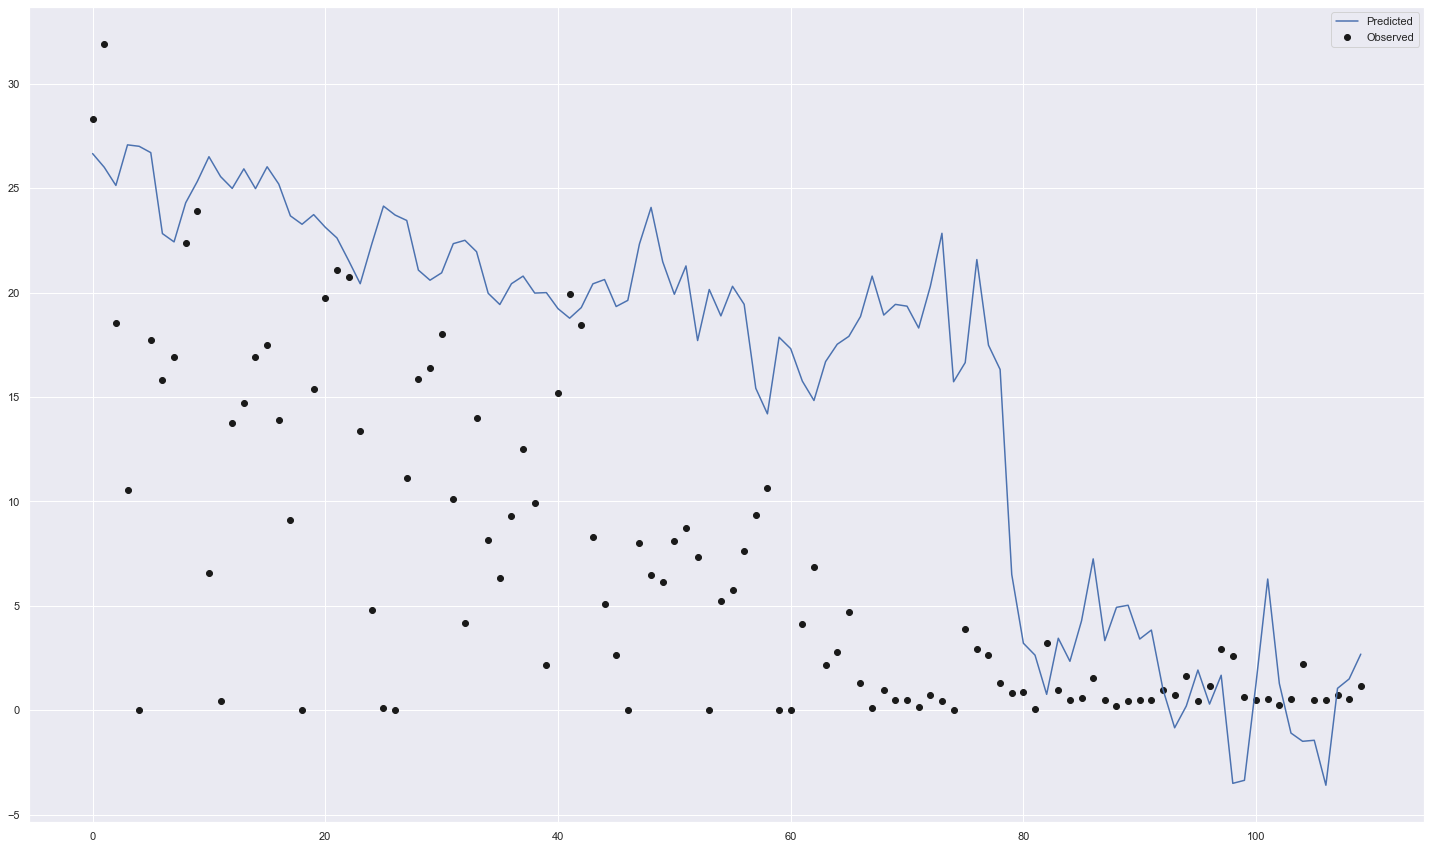

In [40]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='b')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec.: $Y_i$ vs $\\hat{Y}_i$')

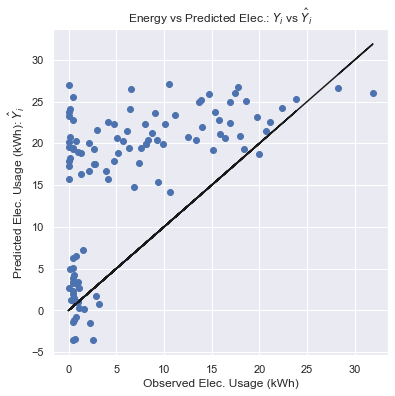

In [41]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='b')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$")
plt.title("Energy vs Predicted Elec.: $Y_i$ vs $\hat{Y}_i$")

### Hourly

In [42]:
correlations = Hotel.corr(method='pearson')
correlations_price = abs(correlations['Electricty Total (KwH)'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Electricty Total (KwH)      1.000000
Fans (KwH)                  0.885992
Lights (KwH)                0.871378
Interior Equipment (KwH)    0.860834
Working_Hour                0.561736
Cooling (KwH)               0.540390
Heating (KwH)               0.495239
Short-wave irradiation      0.183599
Weekend                     0.174638
Hour                        0.097127
Temperature                 0.083142
Season                      0.075068
Day                         0.074011
Snow depth                  0.070413


In [43]:
df = Hotel[['Short-wave irradiation', 'Weekend', 'Hour', 'Temperature', 'Season', 'Electricty Total (KwH)']]

trainSet = df[0:6132]
testSet = df[6133:8760]

XX_elect_train = trainSet.drop('Electricty Total (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Electricty Total (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Electricty Total (KwH)']
YY_elect_test = testSet['Electricty Total (KwH)']

trainSet.head()

Short-wave irradiation  Weekend  Hour  Temperature  Season  \
0                     0.0        0   1.0        37.24       1   
1                     0.0        0   2.0        37.02       1   
2                     0.0        0   3.0        36.77       1   
3                     0.0        0   4.0        36.97       1   
4                     0.0        0   5.0        36.82       1   

   Electricty Total (KwH)  
0                  107.06  
1                   87.08  
2                  101.18  
3                   84.83  
4                   99.31

In [44]:
from sklearn.linear_model import LinearRegression

lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  0.021739191470476316
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0  Short-wave irradiation                 0.050943
1                 Weekend                19.935652
2                    Hour                 0.003290
3             Temperature                -0.802696
4                  Season                 8.554160

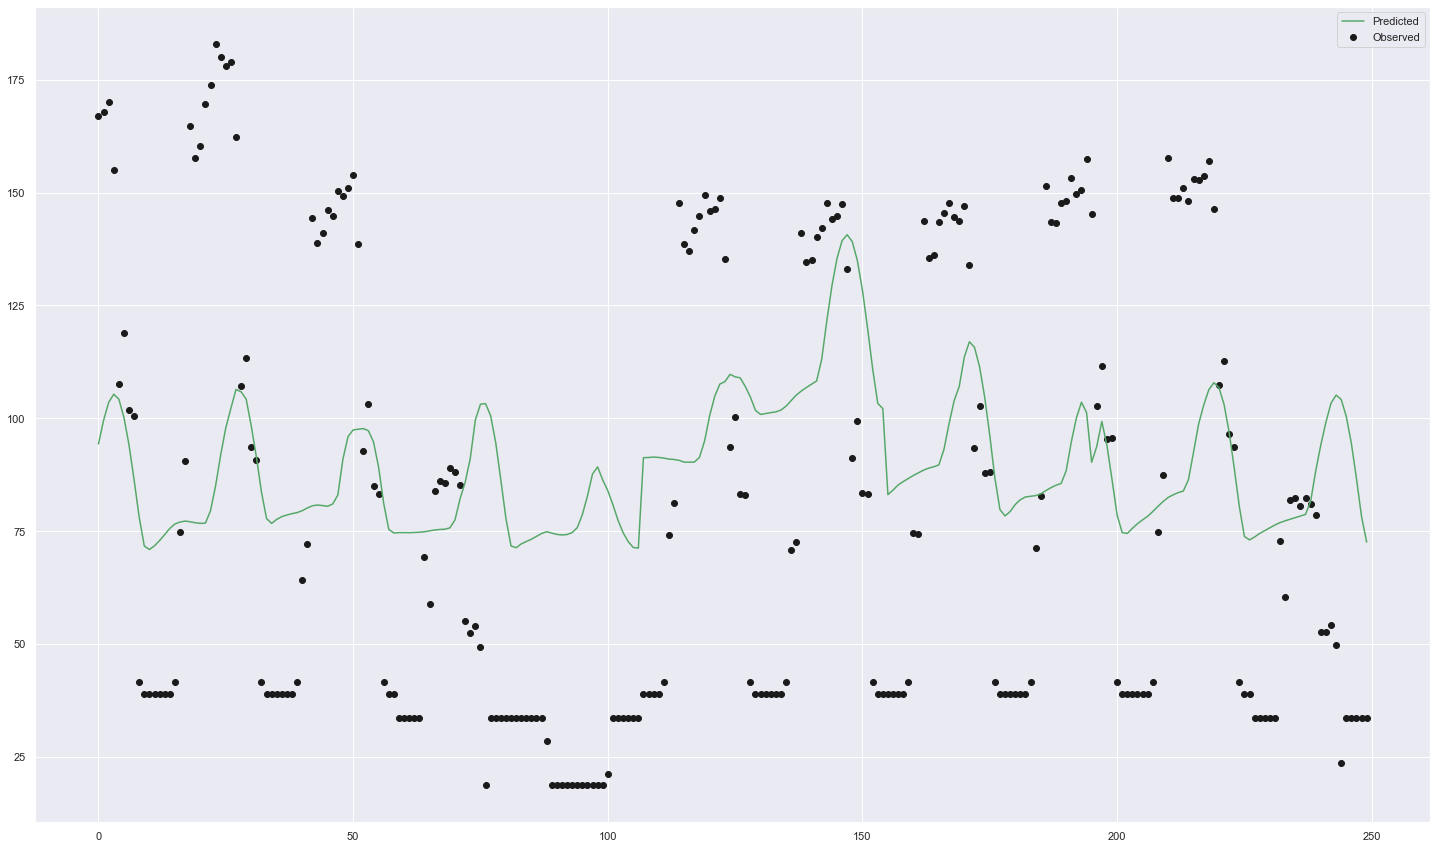

In [45]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='g')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec.: $Y_i$ vs $\\hat{Y}_i$')

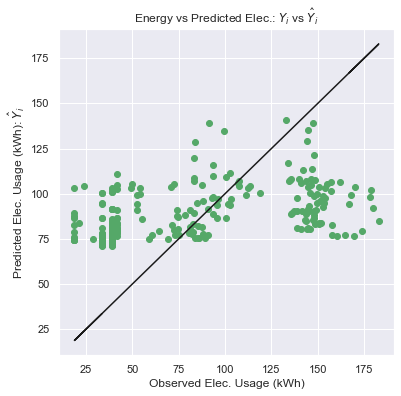

In [46]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='g')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$")
plt.title("Energy vs Predicted Elec.: $Y_i$ vs $\hat{Y}_i$")

In [47]:
correlations = Hotel.corr(method='pearson')
correlations_price = abs(correlations['Heating (KwH)'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Heating (KwH)               1.000000
Electricty Total (KwH)      0.495239
Temperature                 0.440113
Season                      0.358789
Fans (KwH)                  0.275154
Snow depth                  0.258208
Cooling (KwH)               0.201655
Wind speed                  0.180910
Month                       0.177900
Short-wave irradiation      0.126811
Lights (KwH)                0.115655
Interior Equipment (KwH)    0.103515
Snowfall                    0.093073
Relative Humidity           0.079054
Working_Hour                0.072534
Weekend                     0.058165


In [48]:
df = Hotel[['Temperature', 'Season', 'Heating (KwH)']]

trainSet = df[0:6132]
testSet = df[6133:8760]

XX_elect_train = trainSet.drop('Heating (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Heating (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Heating (KwH)']
YY_elect_test = testSet['Heating (KwH)']

trainSet.head()

Temperature  Season  Heating (KwH)
0        37.24       1          68.35
1        37.02       1          49.24
2        36.77       1          62.28
3        36.97       1          46.95
4        36.82       1          60.38

In [49]:
lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  -0.006726280238479099
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0    Temperature                -0.355892
1         Season                -7.325608

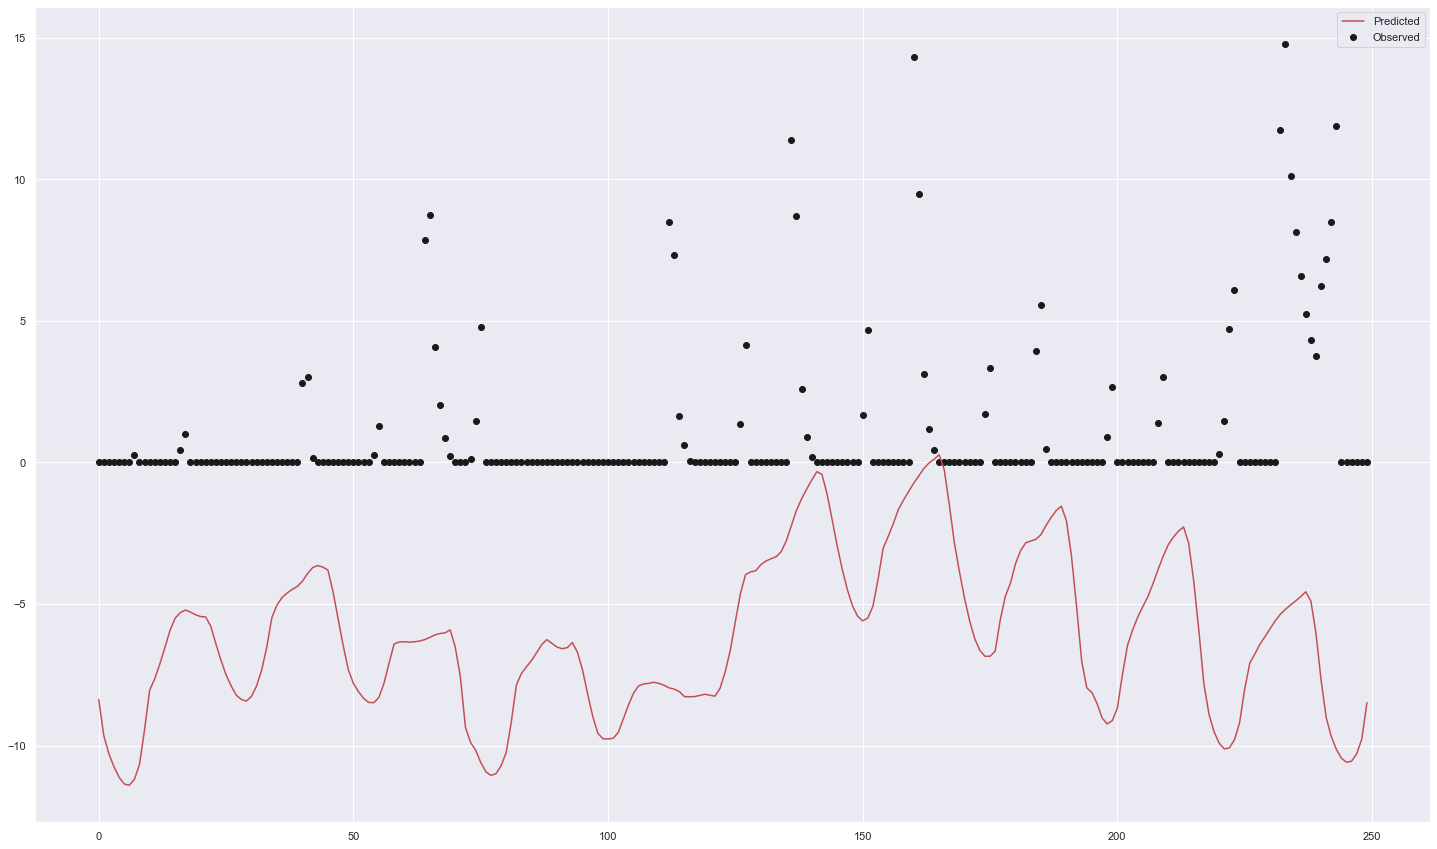

In [50]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='r')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec:')

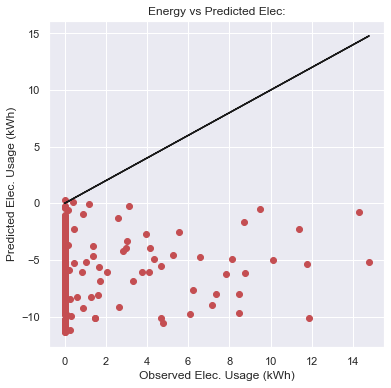

In [51]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='r')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh)")
plt.title("Energy vs Predicted Elec:")

In [52]:
correlations = Hotel.corr(method='pearson')
correlations_price = abs(correlations['Cooling (KwH)'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Cooling (KwH)               1.000000
Fans (KwH)                  0.747820
Electricty Total (KwH)      0.540390
Lights (KwH)                0.492892
Temperature                 0.481401
Interior Equipment (KwH)    0.469451
Working_Hour                0.373260
Short-wave irradiation      0.370431
Season                      0.301206
Wind speed                  0.217112
Heating (KwH)               0.201655
Snow depth                  0.192118
Relative Humidity           0.129224
Month                       0.124754
Hour                        0.080176
Day                         0.071550
Pressure                    0.069225
Snowfall                    0.067604
Wind direction              0.056369
Weekend                     0.055039


In [53]:
df = Hotel[['Working_Hour', 'Short-wave irradiation', 'Season', 'Wind speed', 'Relative Humidity',
            'Month', 'Hour', 'Day', 'Cooling (KwH)']]

trainSet = df[0:6132]
testSet = df[6133:8760]

XX_elect_train = trainSet.drop('Cooling (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Cooling (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Cooling (KwH)']
YY_elect_test = testSet['Cooling (KwH)']

trainSet.head()

Working_Hour  Short-wave irradiation  Season  Wind speed  \
0             0                     0.0       1        5.40   
1             0                     0.0       1        5.71   
2             0                     0.0       1        5.66   
3             0                     0.0       1        6.13   
4             0                     0.0       1        5.83   

   Relative Humidity  Month  Hour  Day  Cooling (KwH)  
0              88.64    1.0   1.0  3.0           2.39  
1              89.75    1.0   2.0  3.0           2.04  
2              90.72    1.0   3.0  3.0           2.53  
3              89.88    1.0   4.0  3.0           2.08  
4              90.32    1.0   5.0  3.0           2.57

In [54]:
lr_elect = LinearRegression()
lr_elect.fit(XX_elect_train, YY_elect_train)

y_lr = lr_elect.predict(XX_elect_test)

print ("The test score R2: ", lr_elect.score(XX_elect_test, YY_elect_test))

print ("The Linear Regression coefficients are")
pd.DataFrame(zip(XX_elect_train.columns, lr_elect.coef_), columns = ['elect_features', 'linearRegr_Coefficients'])

The test score R2:  -7.077185349036041
The Linear Regression coefficients are


elect_features  linearRegr_Coefficients
0            Working_Hour                13.294439
1  Short-wave irradiation                 0.022443
2                  Season                -1.244828
3              Wind speed                -0.414103
4       Relative Humidity                 0.179254
5                   Month                 4.001891
6                    Hour                -0.032128
7                     Day                -0.661546

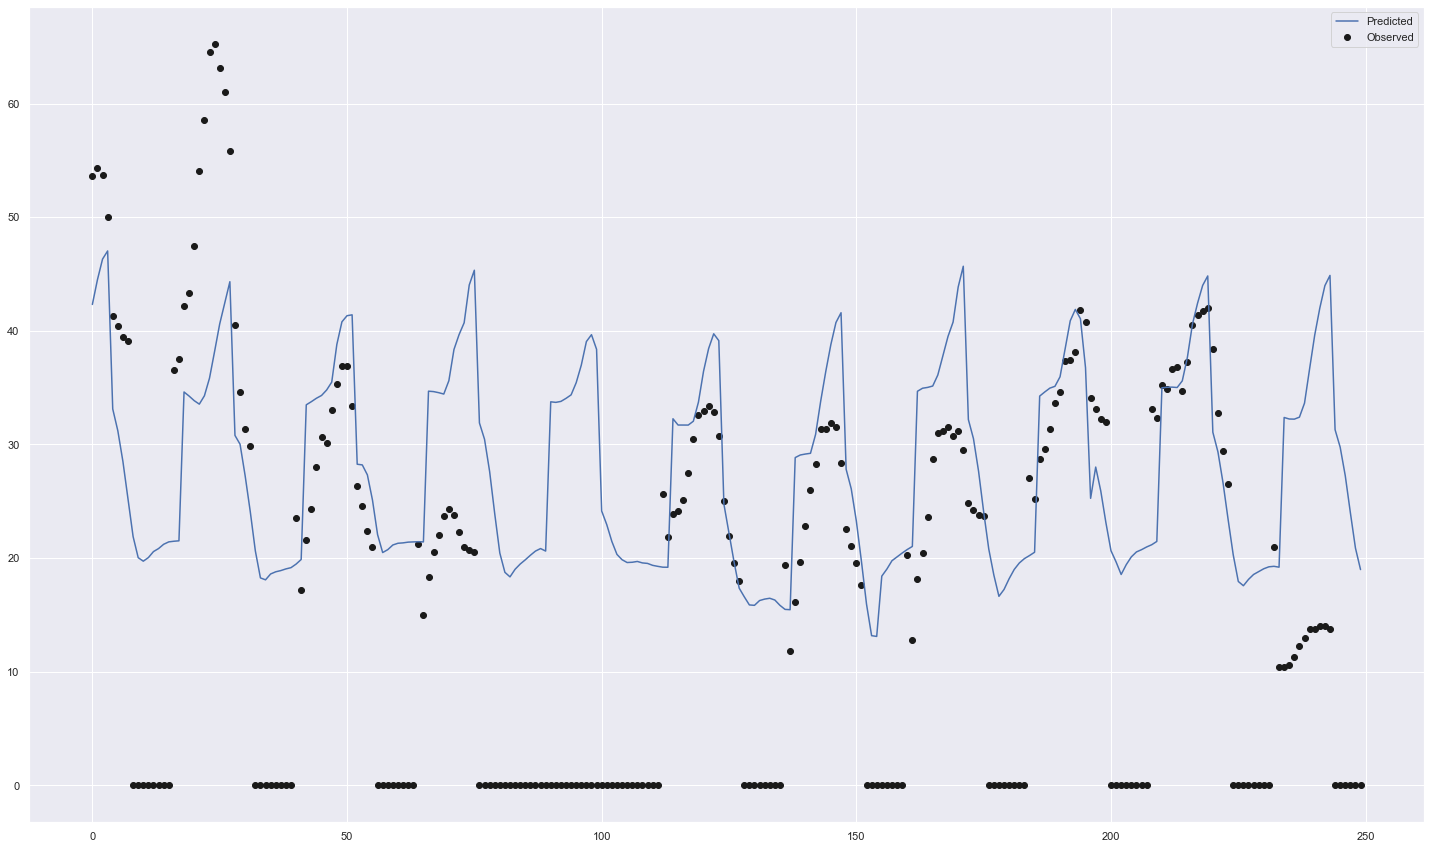

In [55]:
fig = plt.figure(figsize=(25,15))
plt.scatter(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Observed', color='k')
plt.plot(XX_elect_test.index[0:250], y_lr[0:250], label='Predicted', color='b')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Energy vs Predicted Elec:')

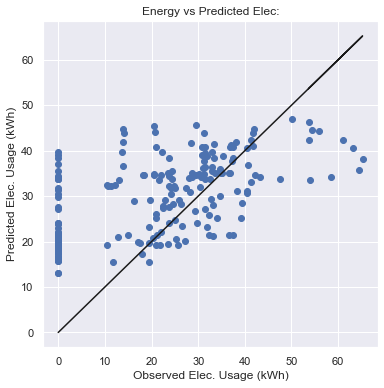

In [56]:
fig = plt.figure(figsize=(6,6))
plt.plot(YY_elect_test[0:250], YY_elect_test[0:250], c='k')
plt.scatter(YY_elect_test[0:250], y_lr[0:250], c='b')
plt.xlabel('Observed Elec. Usage (kWh)')
plt.ylabel("Predicted Elec. Usage (kWh)")
plt.title("Energy vs Predicted Elec:")

## KNN

In [57]:
import sklearn
import sklearn.datasets
import sklearn.model_selection
import sklearn.decomposition
import sklearn.neighbors
import sklearn.metrics

In [58]:
normalized_electricity = Hotel['Electricty Total (KwH)'] - Hotel['Electricty Total (KwH)'].mean()

In [59]:
def accuracy_for_k(k, x, y):
    split_data = sklearn.model_selection.train_test_split(x,y,test_size = 0.33,random_state=99)
    X_train, X_test, Y_train, Y_test = split_data
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'uniform')
    knn.fit(X_train, Y_train)
    value = knn.score(X_test, Y_test)
    return value

In [60]:
df = Hotel[['Short-wave irradiation', 'Weekend', 'Hour', 'Temperature', 'Season', 'Electricty Total (KwH)']]

trainSet = df[0:6132]
testSet = df[6133:8760]

XX_elect_train = trainSet.drop('Electricty Total (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Electricty Total (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Electricty Total (KwH)']
YY_elect_test = testSet['Electricty Total (KwH)']

trainSet.head()

Short-wave irradiation  Weekend  Hour  Temperature  Season  \
0                     0.0        0   1.0        37.24       1   
1                     0.0        0   2.0        37.02       1   
2                     0.0        0   3.0        36.77       1   
3                     0.0        0   4.0        36.97       1   
4                     0.0        0   5.0        36.82       1   

   Electricty Total (KwH)  
0                  107.06  
1                   87.08  
2                  101.18  
3                   84.83  
4                   99.31

0.4137946589060134
The optimal value of k is: 12


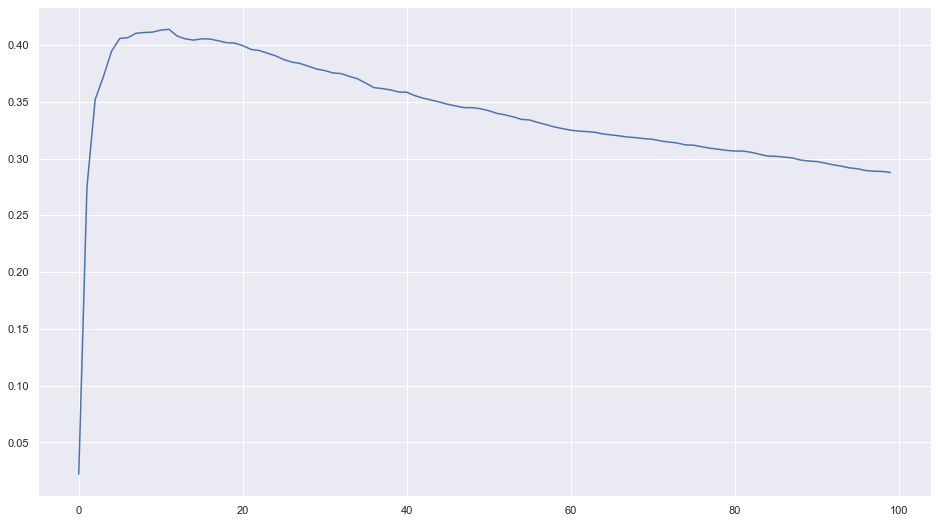

In [61]:
k_values=range(1,101)
scores=np.zeros(len(k_values))
for k, c_k in zip(k_values,range(len(k_values))):
    value=accuracy_for_k(k=k,x= XX_elect_train,y = YY_elect_train)
    scores[c_k]=value
    
k_opt=np.argmax(scores)+1
print (scores.max())
print ('The optimal value of k is:',k_opt)

line1, = plt.plot(scores.T)

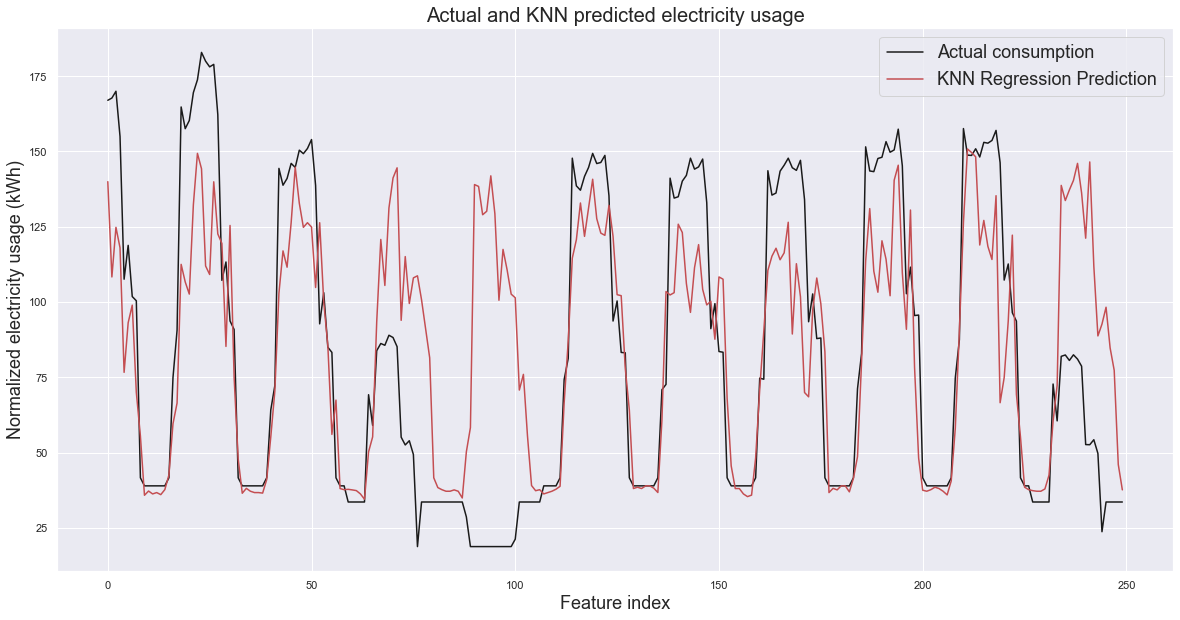

In [62]:
knn_reg=sklearn.neighbors.KNeighborsRegressor(n_neighbors=12,weights='uniform')
knn_reg.fit(XX_elect_train,YY_elect_train)
YY_elect_pred=knn_reg.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, = plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, = plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='KNN Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and KNN predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'KNN Regression Prediction'],fontsize=18)
plt.show()

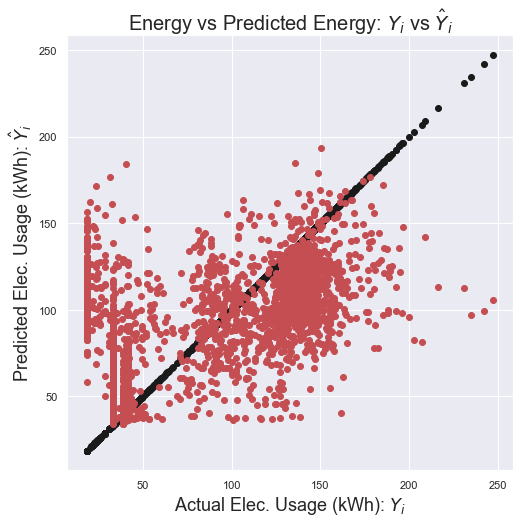

In [63]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)

plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

In [64]:
df = Hotel[['Short-wave irradiation', 'Weekend', 'Hour', 'Temperature', 'Season', 'Cooling (KwH)']]

trainSet = df[0:6132]
testSet = df[6133:8760]

XX_elect_train = trainSet.drop('Cooling (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Cooling (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Cooling (KwH)']
YY_elect_test = testSet['Cooling (KwH)']

trainSet.head()

Short-wave irradiation  Weekend  Hour  Temperature  Season  Cooling (KwH)
0                     0.0        0   1.0        37.24       1           2.39
1                     0.0        0   2.0        37.02       1           2.04
2                     0.0        0   3.0        36.77       1           2.53
3                     0.0        0   4.0        36.97       1           2.08
4                     0.0        0   5.0        36.82       1           2.57

0.5994590606378245
The optimal value of k is: 9


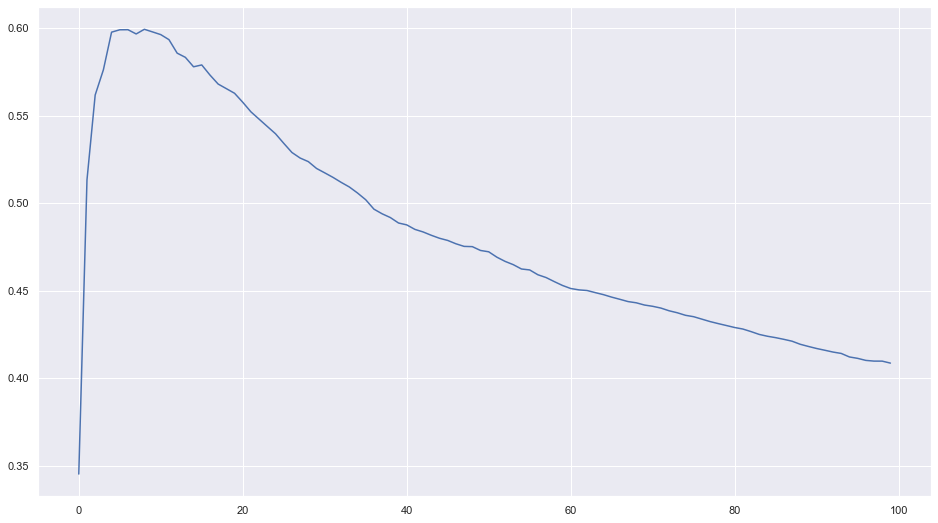

In [65]:
k_values=range(1,101)
scores=np.zeros(len(k_values))
for k, c_k in zip(k_values,range(len(k_values))):
    value=accuracy_for_k(k=k,x= XX_elect_train,y = YY_elect_train)
    scores[c_k]=value
    
k_opt=np.argmax(scores)+1
print (scores.max())
print ('The optimal value of k is:',k_opt)

line1, = plt.plot(scores.T)

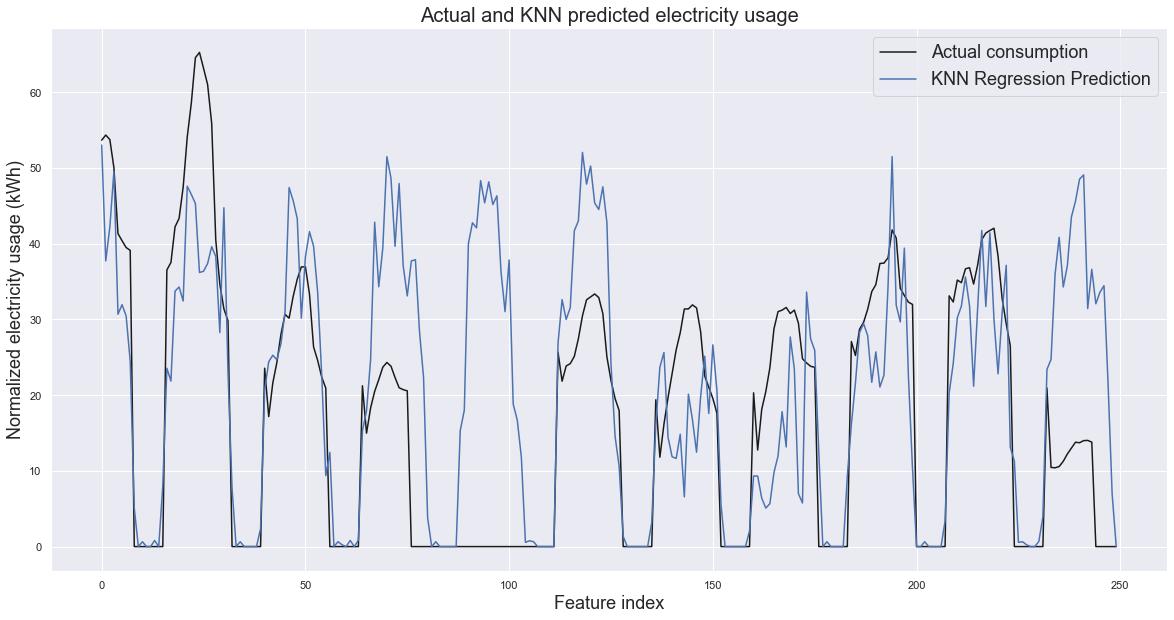

In [66]:
knn_reg=sklearn.neighbors.KNeighborsRegressor(n_neighbors=9,weights='uniform')
knn_reg.fit(XX_elect_train,YY_elect_train)
YY_elect_pred=knn_reg.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, = plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, = plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='KNN Regression Prediction', color='b')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and KNN predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'KNN Regression Prediction'],fontsize=18)
plt.show()

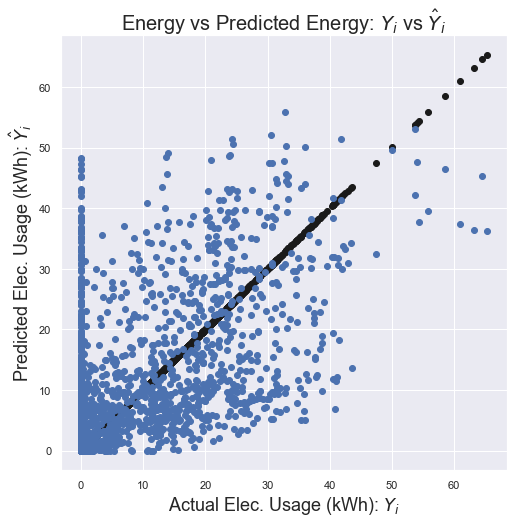

In [67]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='b')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)

plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

In [68]:
df = Hotel[['Short-wave irradiation', 'Weekend', 'Hour', 'Temperature', 'Season', 'Heating (KwH)']]

trainSet = df[0:6132]
testSet = df[6133:8760]

XX_elect_train = trainSet.drop('Heating (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Heating (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Heating (KwH)']
YY_elect_test = testSet['Heating (KwH)']

trainSet.head()

Short-wave irradiation  Weekend  Hour  Temperature  Season  Heating (KwH)
0                     0.0        0   1.0        37.24       1          68.35
1                     0.0        0   2.0        37.02       1          49.24
2                     0.0        0   3.0        36.77       1          62.28
3                     0.0        0   4.0        36.97       1          46.95
4                     0.0        0   5.0        36.82       1          60.38

0.497429809073236
The optimal value of k is: 6


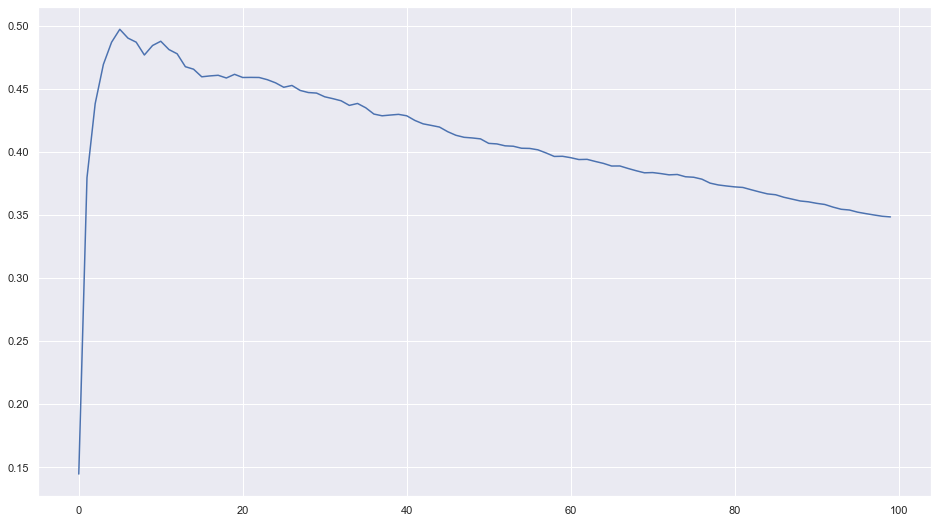

In [69]:
k_values=range(1,101)
scores=np.zeros(len(k_values))
for k, c_k in zip(k_values,range(len(k_values))):
    value=accuracy_for_k(k=k,x= XX_elect_train,y = YY_elect_train)
    scores[c_k]=value
    
k_opt=np.argmax(scores)+1
print (scores.max())
print ('The optimal value of k is:',k_opt)

line1, = plt.plot(scores.T)

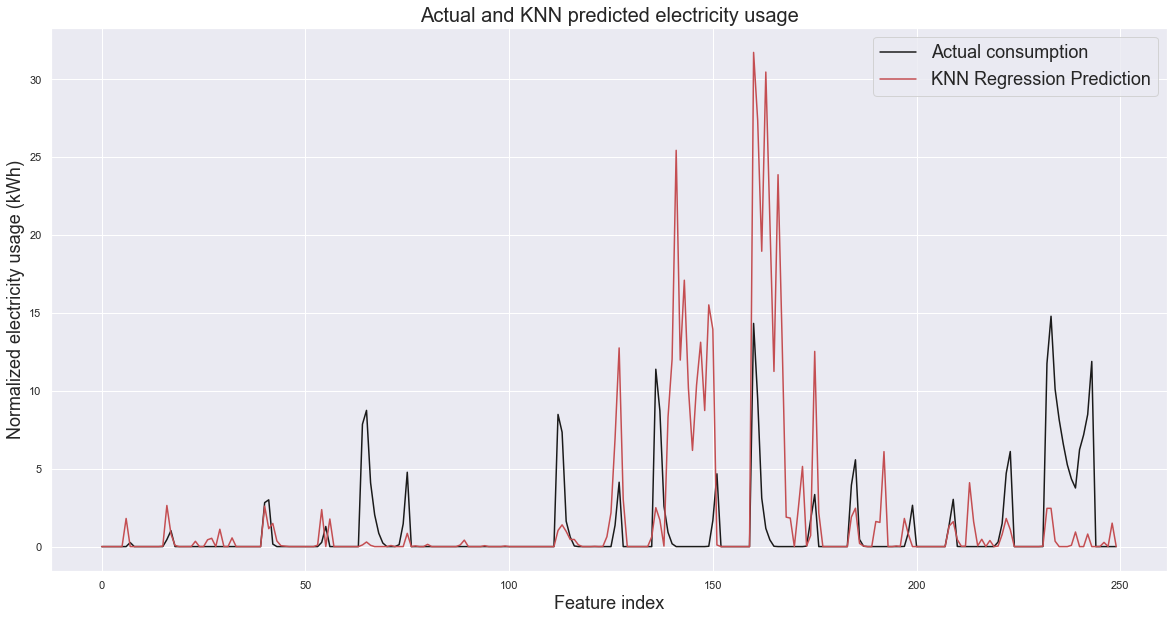

In [70]:
knn_reg=sklearn.neighbors.KNeighborsRegressor(n_neighbors=6,weights='uniform')
knn_reg.fit(XX_elect_train,YY_elect_train)
YY_elect_pred=knn_reg.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, = plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, = plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='KNN Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and KNN predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'KNN Regression Prediction'],fontsize=18)
plt.show()

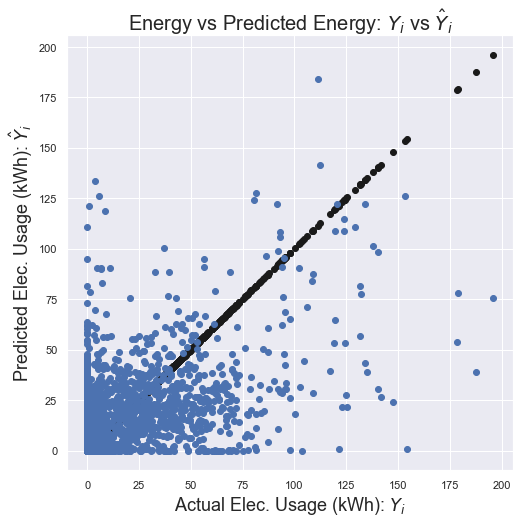

In [71]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='b')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)

plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

## Random Forest

In [72]:
df = Hotel[['Short-wave irradiation', 'Weekend', 'Hour', 'Temperature', 'Season', 'Electricty Total (KwH)']]

trainSet = df[0:6132]
testSet = df[6133:8760]

XX_elect_train = trainSet.drop('Electricty Total (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Electricty Total (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Electricty Total (KwH)']
YY_elect_test = testSet['Electricty Total (KwH)']

trainSet.head()

Short-wave irradiation  Weekend  Hour  Temperature  Season  \
0                     0.0        0   1.0        37.24       1   
1                     0.0        0   2.0        37.02       1   
2                     0.0        0   3.0        36.77       1   
3                     0.0        0   4.0        36.97       1   
4                     0.0        0   5.0        36.82       1   

   Electricty Total (KwH)  
0                  107.06  
1                   87.08  
2                  101.18  
3                   84.83  
4                   99.31

In [73]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import cross_val_score

estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in YY_elect_train]
np.random.seed(11111)

for i in estimators:
    
    model = rfr(n_estimators = i, max_depth = None)
    scores_rfr = cross_val_score(model, XX_elect_train, yt, cv = 10, scoring = 'explained_variance')
    
    print('estimators:', i)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean() + scores_rfr.std()*2) 
    std_rfrs_lower.append(scores_rfr.mean() - scores_rfr.std()*2)

estimators: 2
Est. explained variance: 0.26 (+/- 0.27)

estimators: 5
Est. explained variance: 0.38 (+/- 0.20)

estimators: 10
Est. explained variance: 0.39 (+/- 0.21)

estimators: 15
Est. explained variance: 0.41 (+/- 0.19)

estimators: 20
Est. explained variance: 0.41 (+/- 0.21)

estimators: 25
Est. explained variance: 0.43 (+/- 0.20)

estimators: 30
Est. explained variance: 0.43 (+/- 0.19)

estimators: 35
Est. explained variance: 0.43 (+/- 0.17)

estimators: 40
Est. explained variance: 0.43 (+/- 0.18)

estimators: 45
Est. explained variance: 0.43 (+/- 0.19)

estimators: 50
Est. explained variance: 0.43 (+/- 0.18)

estimators: 55
Est. explained variance: 0.44 (+/- 0.18)

estimators: 60
Est. explained variance: 0.43 (+/- 0.19)

estimators: 65
Est. explained variance: 0.43 (+/- 0.18)

estimators: 70
Est. explained variance: 0.43 (+/- 0.19)

estimators: 75
Est. explained variance: 0.43 (+/- 0.19)

estimators: 80
Est. explained variance: 0.44 (+/- 0.18)



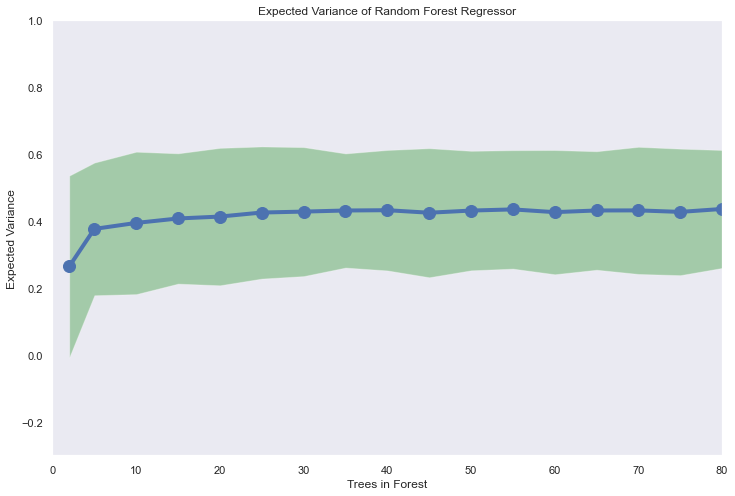

In [74]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)

ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)

ax.set_ylim([-.3,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

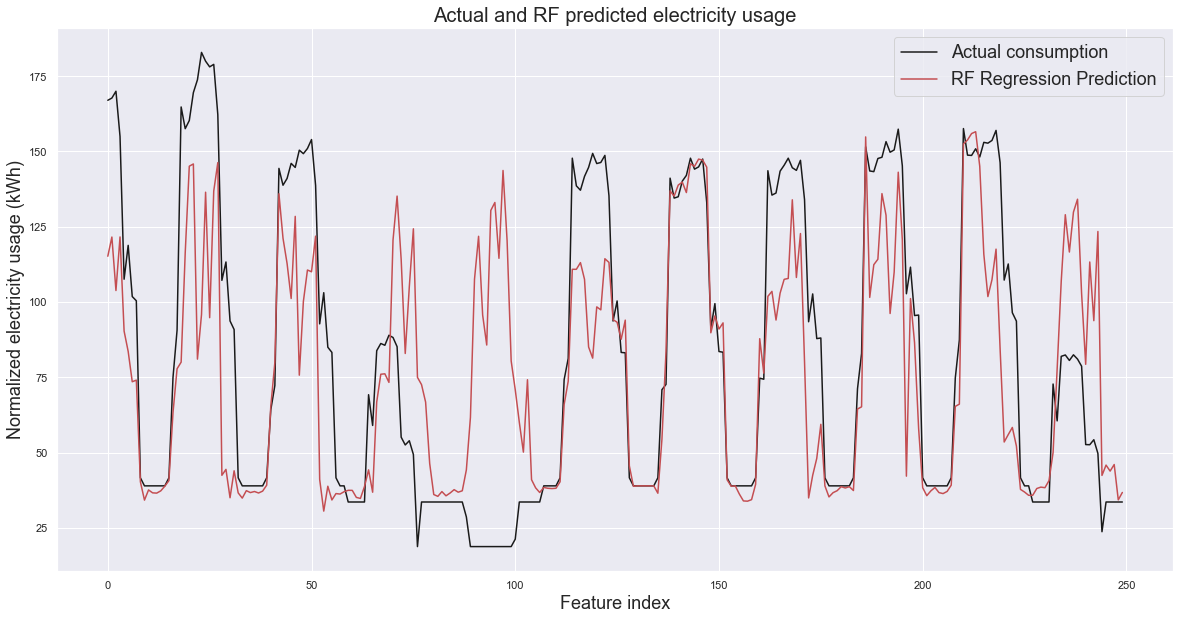

In [75]:
from sklearn.ensemble import RandomForestRegressor

RF_e = RandomForestRegressor(n_estimators = 20, max_depth=None, min_samples_split = 4, random_state=0)
RF_e.fit(XX_elect_train, YY_elect_train)
YY_elect_pred=RF_e.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, =plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='RF Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and RF predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'RF Regression Prediction'],fontsize=18)
plt.show()

In [76]:
print (RF_e.score(XX_elect_test,YY_elect_test))

0.29645870476963976


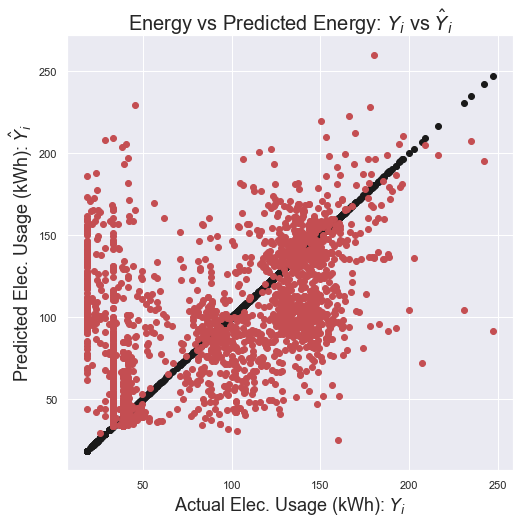

In [77]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)
plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

In [78]:
df = Hotel[['Short-wave irradiation', 'Weekend', 'Hour', 'Temperature', 'Season', 'Cooling (KwH)']]

trainSet = df[0:6132]
testSet = df[6133:8760]

XX_elect_train = trainSet.drop('Cooling (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Cooling (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Cooling (KwH)']
YY_elect_test = testSet['Cooling (KwH)']

trainSet.head()

Short-wave irradiation  Weekend  Hour  Temperature  Season  Cooling (KwH)
0                     0.0        0   1.0        37.24       1           2.39
1                     0.0        0   2.0        37.02       1           2.04
2                     0.0        0   3.0        36.77       1           2.53
3                     0.0        0   4.0        36.97       1           2.08
4                     0.0        0   5.0        36.82       1           2.57

In [79]:
estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in YY_elect_train]
np.random.seed(11111)

for i in estimators:
    
    model = rfr(n_estimators = i, max_depth = None)
    scores_rfr = cross_val_score(model, XX_elect_train, yt, cv = 10, scoring = 'explained_variance')
    
    print('estimators:', i)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean() + scores_rfr.std()*2) 
    std_rfrs_lower.append(scores_rfr.mean() - scores_rfr.std()*2)

estimators: 2
Est. explained variance: 0.02 (+/- 0.95)

estimators: 5
Est. explained variance: 0.15 (+/- 0.78)

estimators: 10
Est. explained variance: 0.22 (+/- 0.64)

estimators: 15
Est. explained variance: 0.23 (+/- 0.68)

estimators: 20
Est. explained variance: 0.24 (+/- 0.64)

estimators: 25
Est. explained variance: 0.25 (+/- 0.65)

estimators: 30
Est. explained variance: 0.25 (+/- 0.64)

estimators: 35
Est. explained variance: 0.23 (+/- 0.68)

estimators: 40
Est. explained variance: 0.25 (+/- 0.65)

estimators: 45
Est. explained variance: 0.26 (+/- 0.61)

estimators: 50
Est. explained variance: 0.27 (+/- 0.60)

estimators: 55
Est. explained variance: 0.27 (+/- 0.60)

estimators: 60
Est. explained variance: 0.26 (+/- 0.62)

estimators: 65
Est. explained variance: 0.26 (+/- 0.63)

estimators: 70
Est. explained variance: 0.28 (+/- 0.59)

estimators: 75
Est. explained variance: 0.26 (+/- 0.62)

estimators: 80
Est. explained variance: 0.26 (+/- 0.63)



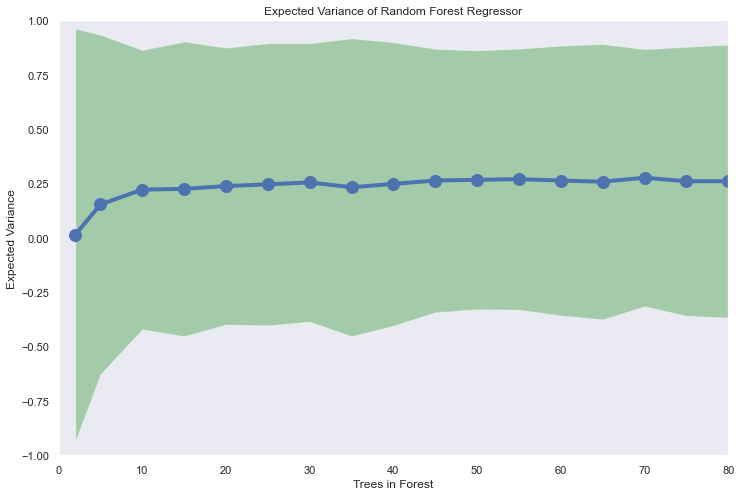

In [80]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
ax.plot(estimators, mean_rfrs,marker='o', linewidth=4,markersize=12)

ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,facecolor='green',alpha=0.3,interpolate=True)

ax.set_ylim([-1,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

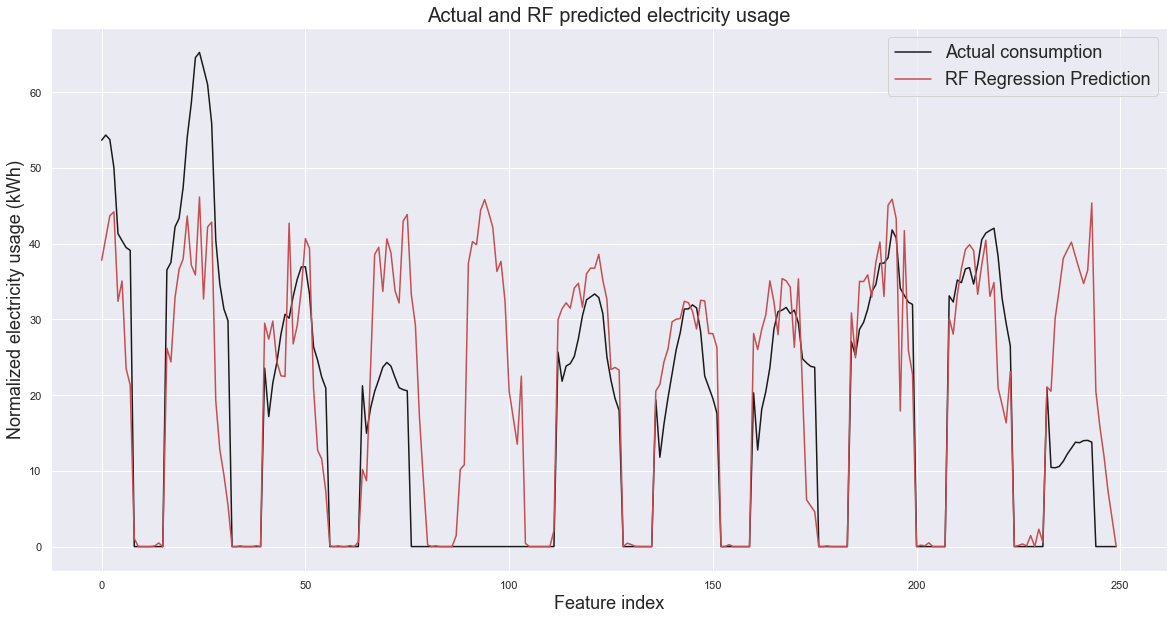

In [81]:
RF_e = RandomForestRegressor(n_estimators = 35, max_depth=None, min_samples_split = 4, random_state=0)
RF_e.fit(XX_elect_train, YY_elect_train)
YY_elect_pred=RF_e.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, =plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='RF Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and RF predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'RF Regression Prediction'],fontsize=18)
plt.show()

In [82]:
print (RF_e.score(XX_elect_test,YY_elect_test))

-0.9124700071093388


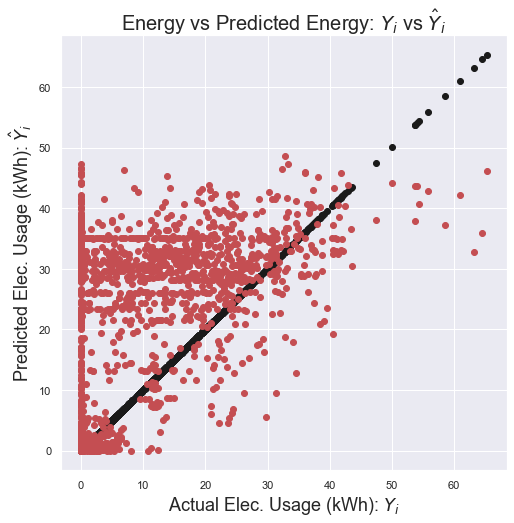

In [83]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)
plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

In [84]:
df = Hotel[['Short-wave irradiation', 'Weekend', 'Hour', 'Temperature', 'Season', 'Heating (KwH)']]

trainSet = df[0:6132]
testSet = df[6133:8760]

XX_elect_train = trainSet.drop('Heating (KwH)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = testSet.drop('Heating (KwH)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = trainSet['Heating (KwH)']
YY_elect_test = testSet['Heating (KwH)']

trainSet.head()

Short-wave irradiation  Weekend  Hour  Temperature  Season  Heating (KwH)
0                     0.0        0   1.0        37.24       1          68.35
1                     0.0        0   2.0        37.02       1          49.24
2                     0.0        0   3.0        36.77       1          62.28
3                     0.0        0   4.0        36.97       1          46.95
4                     0.0        0   5.0        36.82       1          60.38

In [85]:
estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in YY_elect_train]
np.random.seed(11111)

for i in estimators:
    
    model = rfr(n_estimators = i, max_depth = None)
    scores_rfr = cross_val_score(model, XX_elect_train, yt, cv = 10, scoring = 'explained_variance')
    
    print('estimators:', i)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean() + scores_rfr.std()*2) 
    std_rfrs_lower.append(scores_rfr.mean() - scores_rfr.std()*2)

estimators: 2
Est. explained variance: -1.58 (+/- 5.24)

estimators: 5
Est. explained variance: -1.07 (+/- 3.78)

estimators: 10
Est. explained variance: -1.02 (+/- 3.99)

estimators: 15
Est. explained variance: -0.66 (+/- 3.18)

estimators: 20
Est. explained variance: -0.76 (+/- 3.45)

estimators: 25
Est. explained variance: -0.71 (+/- 3.41)

estimators: 30
Est. explained variance: -0.65 (+/- 2.83)

estimators: 35
Est. explained variance: -0.76 (+/- 3.56)

estimators: 40
Est. explained variance: -0.60 (+/- 3.15)

estimators: 45
Est. explained variance: -0.60 (+/- 3.13)

estimators: 50
Est. explained variance: -0.56 (+/- 3.06)

estimators: 55
Est. explained variance: -0.59 (+/- 3.07)

estimators: 60
Est. explained variance: -0.59 (+/- 3.20)

estimators: 65
Est. explained variance: -0.69 (+/- 3.30)

estimators: 70
Est. explained variance: -0.58 (+/- 3.17)

estimators: 75
Est. explained variance: -0.69 (+/- 3.43)

estimators: 80
Est. explained variance: -0.62 (+/- 3.14)



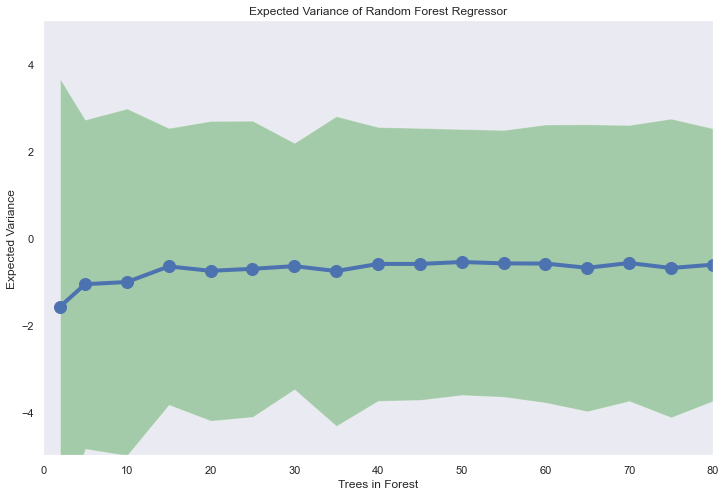

In [86]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)

ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)

ax.set_ylim([-5,5])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

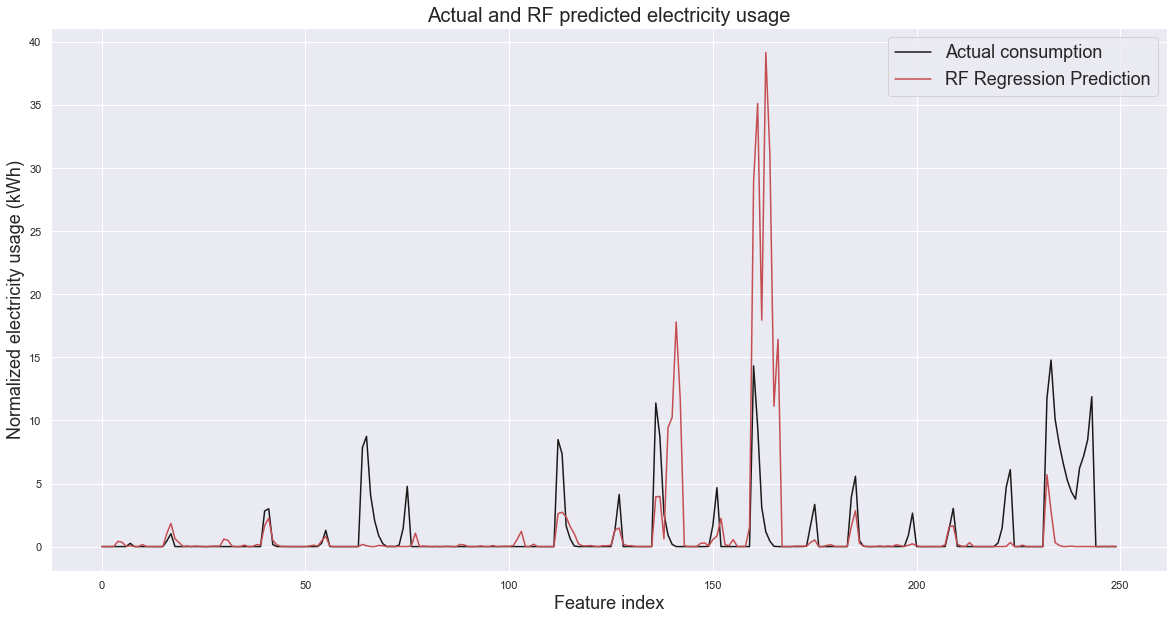

In [87]:
RF_e = RandomForestRegressor(n_estimators = 50, max_depth=None, min_samples_split = 4, random_state=0)
RF_e.fit(XX_elect_train, YY_elect_train)
YY_elect_pred=RF_e.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_elect_test.index[0:250], YY_elect_test[0:250], label='Actual consumption', color='k')
line2, =plt.plot(XX_elect_test.index[0:250], YY_elect_pred[0:250], label='RF Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and RF predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'RF Regression Prediction'],fontsize=18)
plt.show()

In [88]:
print (RF_e.score(XX_elect_test,YY_elect_test))

0.10757271607232344


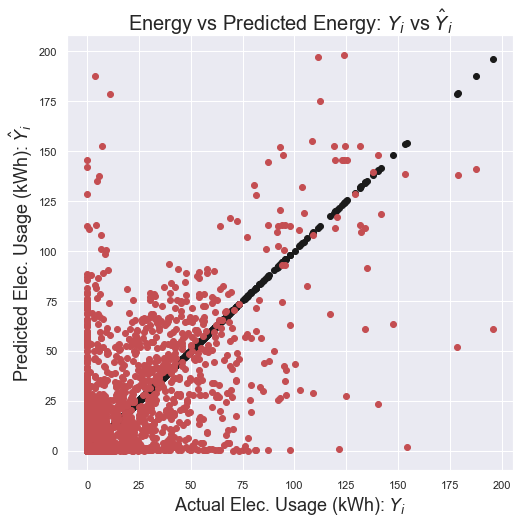

In [89]:
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)
plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

## NN

In [90]:
features = ['Temperature', 'Season', 'Snow depth', 'Wind speed', 'Month', 'Short-wave irradiation', 'Snowfall',
           'Relative Humidity', 'Working_Hour', 'Weekend']

In [91]:
def plot_model_rmse_and_loss(history):
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [92]:
def plot_learning_rate_schedule(history_lr, max_loss):
    plt.semilogx(history_lr.history['lr'], history_lr.history['loss'])
    plt.axis([1e-4, 1, 0, max_loss])
    plt.xlabel('Learning Rate')
    plt.ylabel('Training Loss')
    plt.show()

In [93]:
print(len(Hotel))

8760


In [94]:
def naive(Data):
    
    y = Hotel['Heating (KwH)'].values

    y_train = y[:5900]
    y_cv = y[5900 : 7200]
    y_test = y[7200:]
    
    naive_hour_ahead = y[7200 - 1 : 8760 - 1]
    rmse_naive = sqrt(mean_squared_error(y_test, naive_hour_ahead))

    print('RMSE of hour-ahead electricity price naive forecast: {}'.format(round(rmse_naive, 3)))

naive(Hotel)

RMSE of hour-ahead electricity price naive forecast: 25.088


In [95]:
def Nueral_Network (dataset, target, start, end, timesteps):
    
    data = []
    labels = []

    if end is None:
        end = len(dataset)
        
    for i in range(start, end):
        
        indices = range(i - timesteps, i)
        data.append(dataset[indices])
        labels.append(target[i])

    return np.array(data), np.array(labels)

In [96]:
train_set = 5900
validation_set = 7200
test_set = 8760

In [97]:
dataset = Hotel[features]

In [98]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

timesteps = 3
scaler_all = MinMaxScaler(feature_range=(0, 1))
scaler_all.fit(dataset[:train_set])
scaled_dataset = scaler_all.transform(dataset)

Hotel = Hotel['Electricty Total (KwH)'].values

scaler = MinMaxScaler(feature_range=(0, 1))

Hotel_reshaped = Hotel.reshape(-1, 1)
scaler.fit(Hotel_reshaped[:train_set])

scaled_variable = scaler.transform(Hotel_reshaped)
scaled_dataset = np.concatenate((scaled_dataset, scaled_variable), axis=1)

X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [99]:
X_train, y_train = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], 0, train_set, timesteps)
X_val, y_val = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], train_set, validation_set, timesteps)
X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [100]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))

y_test_reshaped = y_test.reshape(-1, 1)
y_test_inv = scaler.inverse_transform(y_test_reshaped)

batch_size = 64
shuffle_size = 64

val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

In [101]:
tf.keras.backend.clear_session()
from keras import regularizers

mlp_lr = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, kernel_regularizer=regularizers.l2(0.0009), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = 1e-4, amsgrad=True)
mlp_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)

Using TensorFlow backend.


In [102]:
Learning_Rate = mlp_lr.fit(train, epochs = 50, validation_data = val, callbacks=[lr_schedule])

Epoch 1/50
93/93 [==============================] - 0s 3ms/step - loss: 0.0437 - root_mean_squared_error: 0.1605 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1070
Epoch 2/50
93/93 [==============================] - 0s 2ms/step - loss: 0.0293 - root_mean_squared_error: 0.1116 - val_loss: 0.0229 - val_root_mean_squared_error: 0.0819
Epoch 3/50
93/93 [==============================] - 0s 2ms/step - loss: 0.0245 - root_mean_squared_error: 0.0948 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0878
Epoch 4/50
93/93 [==============================] - 0s 2ms/step - loss: 0.0216 - root_mean_squared_error: 0.0861 - val_loss: 0.0200 - val_root_mean_squared_error: 0.0807
Epoch 5/50
93/93 [==============================] - 0s 3ms/step - loss: 0.0194 - root_mean_squared_error: 0.0818 - val_loss: 0.0179 - val_root_mean_squared_error: 0.0774
Epoch 6/50
93/93 [==============================] - 0s 3ms/step - loss: 0.0176 - root_mean_squared_error: 0.0803 - val_loss: 0.0166 - val_root_mean_sq

Epoch 49/50
93/93 [==============================] - 0s 2ms/step - loss: 95.7407 - root_mean_squared_error: 8.2011 - val_loss: 28.5074 - val_root_mean_squared_error: 0.5093
Epoch 50/50
93/93 [==============================] - 0s 2ms/step - loss: 74.9693 - root_mean_squared_error: 6.8515 - val_loss: 28.6661 - val_root_mean_squared_error: 0.9624


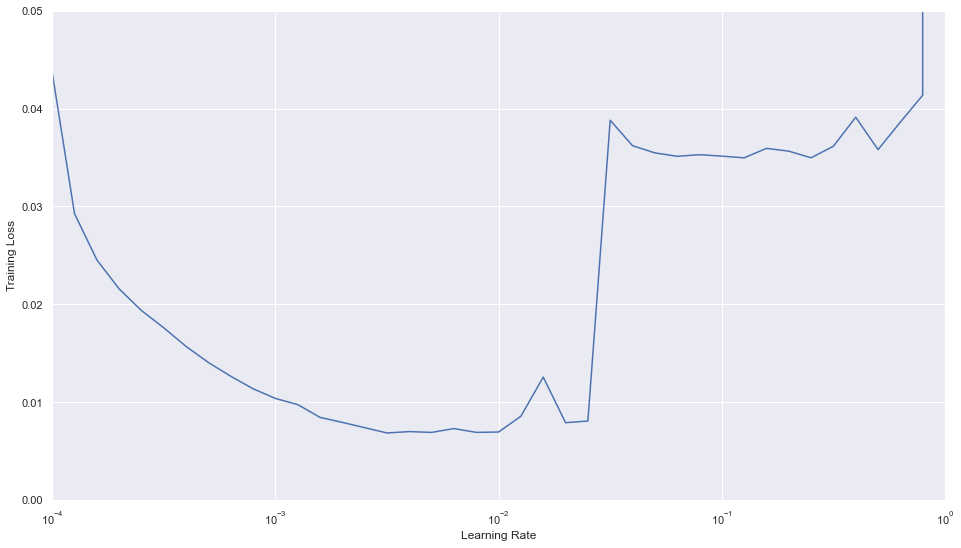

In [103]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [104]:
tf.keras.backend.clear_session()

MLP =  tf.keras.models.Sequential([
    TimeDistributed(Dense(150, kernel_regularizer=regularizers.l2(0.001), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(100, kernel_regularizer=regularizers.l2(0.001), activation='relu')),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.1),
    Dense(1)  
])

optimizer = tf.keras.optimizers.Adam(lr = 0.009, amsgrad= True)
MLP.compile(loss = loss, optimizer = optimizer, metrics = metric)
MLP_Model = MLP.fit(train, epochs = 100, validation_data = val)

Epoch 1/100
93/93 [==============================] - 0s 3ms/step - loss: 0.0566 - root_mean_squared_error: 0.4265 - val_loss: 0.0157 - val_root_mean_squared_error: 0.0655
Epoch 2/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0149 - root_mean_squared_error: 0.0901 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0553
Epoch 3/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0107 - root_mean_squared_error: 0.0871 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0535
Epoch 4/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0124 - root_mean_squared_error: 0.1000 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0621
Epoch 5/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0096 - root_mean_squared_error: 0.0879 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0574
Epoch 6/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0106 - root_mean_squared_error: 0.0940 - val_loss: 0.0070 - val_root_m

Epoch 49/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0080 - root_mean_squared_error: 0.0838 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0527
Epoch 50/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0085 - root_mean_squared_error: 0.0859 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0547
Epoch 51/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0079 - root_mean_squared_error: 0.0827 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0535
Epoch 52/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0085 - root_mean_squared_error: 0.0859 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0540
Epoch 53/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0084 - root_mean_squared_error: 0.0849 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0596
Epoch 54/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0078 - root_mean_squared_error: 0.0817 - val_loss: 0.0044 - val_

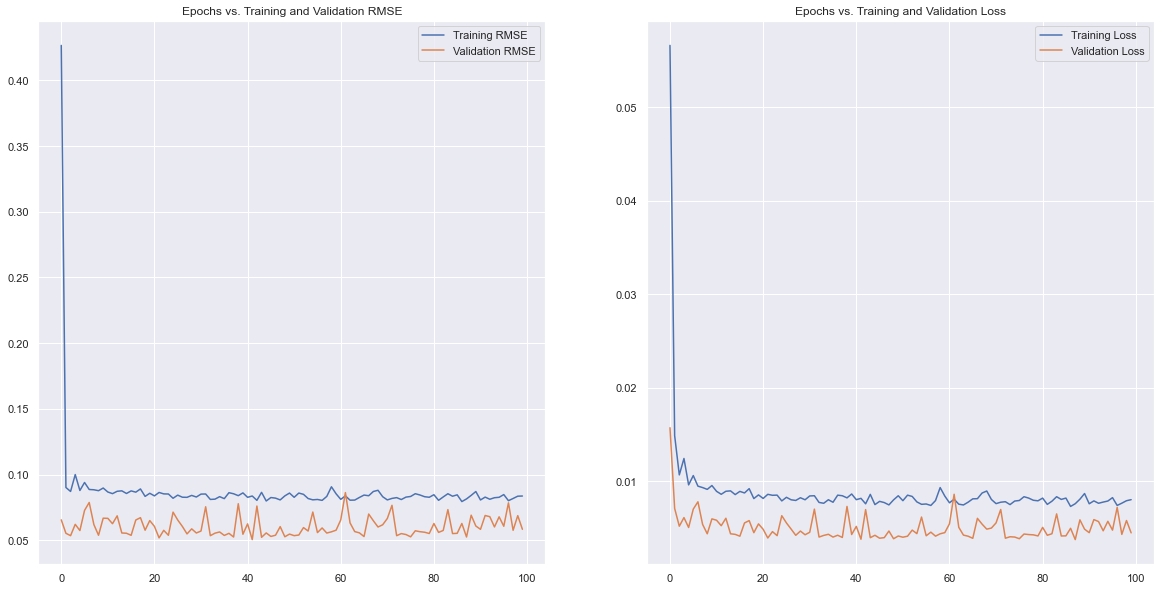

In [105]:
plot_model_rmse_and_loss(MLP_Model)

In [106]:
forecast = MLP.predict(X_test)
MLP_forecast = scaler.inverse_transform(forecast)

rmse_mlp = sqrt(mean_squared_error(y_test_inv, MLP_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}' .format(round(rmse_mlp, 3)))

RMSE of hour-ahead electricity price multivariate MLP forecast: 34.69


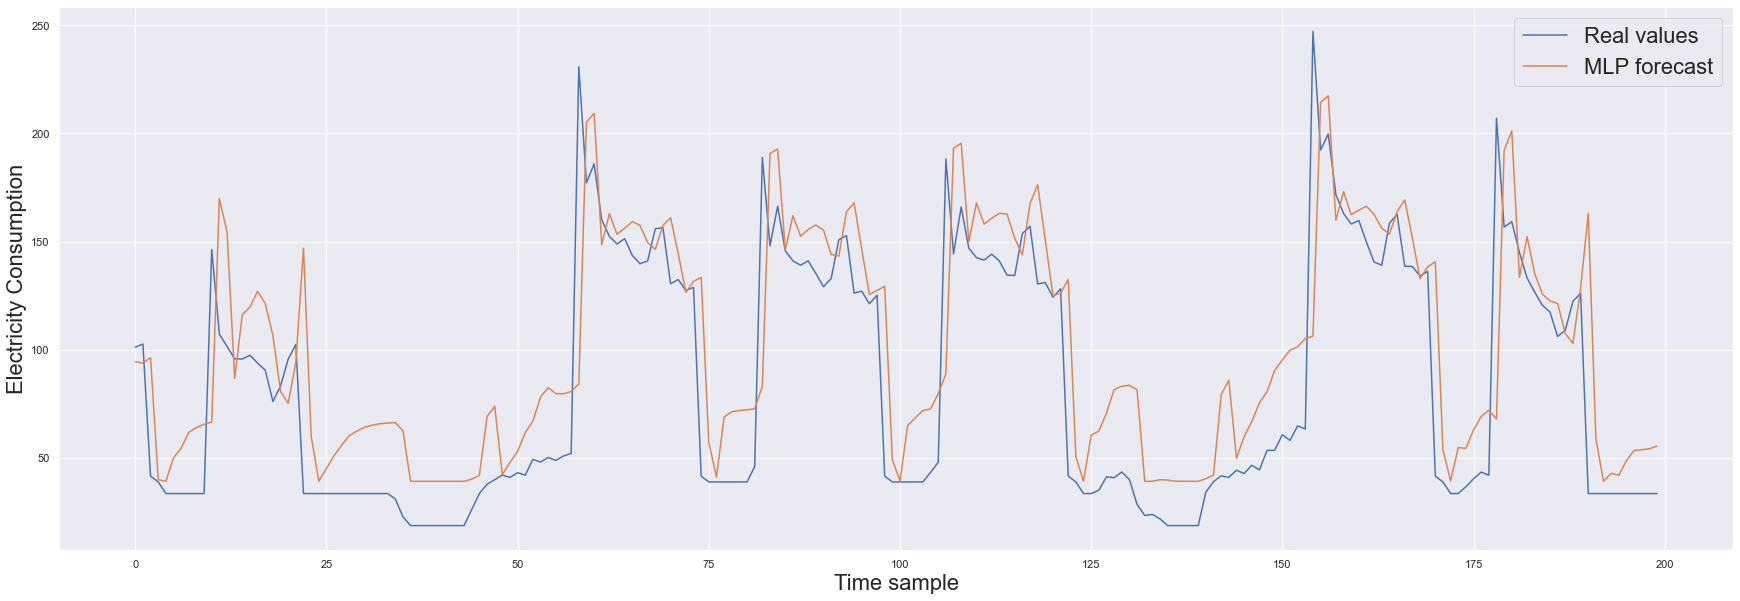

In [107]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[500:700], label='Real values')
ax.plot(MLP_forecast[500:700], label='MLP forecast')
ax.legend(prop={'size':22})
plt.show()

In [108]:
tf.keras.backend.clear_session()

lstm_learning = tf.keras.models.Sequential([
    LSTM(50, input_shape = input_shape, return_sequences=True),
    Flatten(),
    Dense(100, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
lstm_learning.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [109]:
Learning_Rate = lstm_learning.fit(train, epochs = 50, validation_data = val, callbacks = [lr_schedule])

Epoch 1/50
93/93 [==============================] - 1s 8ms/step - loss: 0.1538 - root_mean_squared_error: 0.2016 - val_loss: 0.1187 - val_root_mean_squared_error: 0.1329
Epoch 2/50
93/93 [==============================] - 0s 4ms/step - loss: 0.1194 - root_mean_squared_error: 0.1527 - val_loss: 0.1042 - val_root_mean_squared_error: 0.1148
Epoch 3/50
93/93 [==============================] - 0s 4ms/step - loss: 0.1032 - root_mean_squared_error: 0.1343 - val_loss: 0.0890 - val_root_mean_squared_error: 0.0981
Epoch 4/50
93/93 [==============================] - 0s 3ms/step - loss: 0.0876 - root_mean_squared_error: 0.1210 - val_loss: 0.0739 - val_root_mean_squared_error: 0.0852
Epoch 5/50
93/93 [==============================] - 0s 3ms/step - loss: 0.0726 - root_mean_squared_error: 0.1126 - val_loss: 0.0598 - val_root_mean_squared_error: 0.0790
Epoch 6/50
93/93 [==============================] - 0s 4ms/step - loss: 0.0581 - root_mean_squared_error: 0.1054 - val_loss: 0.0460 - val_root_mean_sq

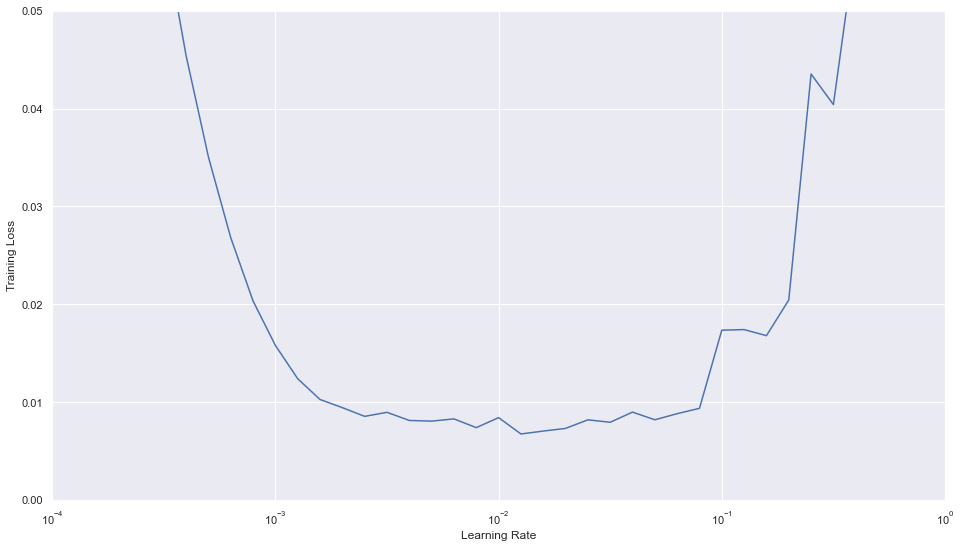

In [110]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [111]:
tf.keras.backend.clear_session()

LSTM = tf.keras.models.Sequential([
    LSTM(100, input_shape = input_shape, return_sequences = True),
    Flatten(),
    Dense(150, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = .001, amsgrad=True)
LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
LSTM_Model = LSTM.fit(train, epochs = 75, validation_data = val)  

Epoch 1/75
93/93 [==============================] - 1s 8ms/step - loss: 0.1196 - root_mean_squared_error: 121.4251 - val_loss: 0.0557 - val_root_mean_squared_error: 0.0869
Epoch 2/75
93/93 [==============================] - 0s 5ms/step - loss: 0.0397 - root_mean_squared_error: 0.1001 - val_loss: 0.0248 - val_root_mean_squared_error: 0.0861
Epoch 3/75
93/93 [==============================] - 0s 5ms/step - loss: 0.0210 - root_mean_squared_error: 0.0951 - val_loss: 0.0154 - val_root_mean_squared_error: 0.0860
Epoch 4/75
93/93 [==============================] - 0s 5ms/step - loss: 0.0144 - root_mean_squared_error: 0.0914 - val_loss: 0.0134 - val_root_mean_squared_error: 0.0948
Epoch 5/75
93/93 [==============================] - 0s 5ms/step - loss: 0.0111 - root_mean_squared_error: 0.0869 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0820
Epoch 6/75
93/93 [==============================] - 0s 5ms/step - loss: 0.0094 - root_mean_squared_error: 0.0842 - val_loss: 0.0081 - val_root_mean_

Epoch 49/75
93/93 [==============================] - 0s 5ms/step - loss: 0.0056 - root_mean_squared_error: 0.0726 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0586
Epoch 50/75
93/93 [==============================] - 0s 4ms/step - loss: 0.0055 - root_mean_squared_error: 0.0720 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0639
Epoch 51/75
93/93 [==============================] - 0s 4ms/step - loss: 0.0056 - root_mean_squared_error: 0.0724 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0630
Epoch 52/75
93/93 [==============================] - 0s 4ms/step - loss: 0.0055 - root_mean_squared_error: 0.0716 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0598
Epoch 53/75
93/93 [==============================] - 0s 5ms/step - loss: 0.0056 - root_mean_squared_error: 0.0723 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0613
Epoch 54/75
93/93 [==============================] - 0s 5ms/step - loss: 0.0056 - root_mean_squared_error: 0.0726 - val_loss: 0.0044 - val_root_m

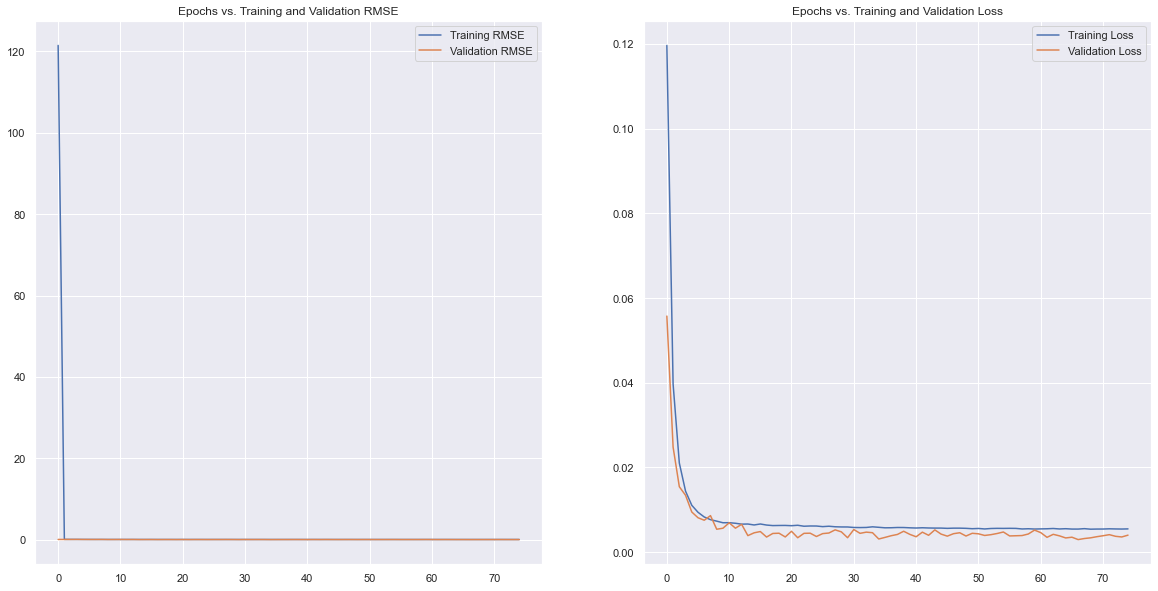

In [112]:
plot_model_rmse_and_loss(LSTM_Model)

In [113]:
forecast = LSTM.predict(X_test)
LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv, LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate LSTM forecast: 31.046


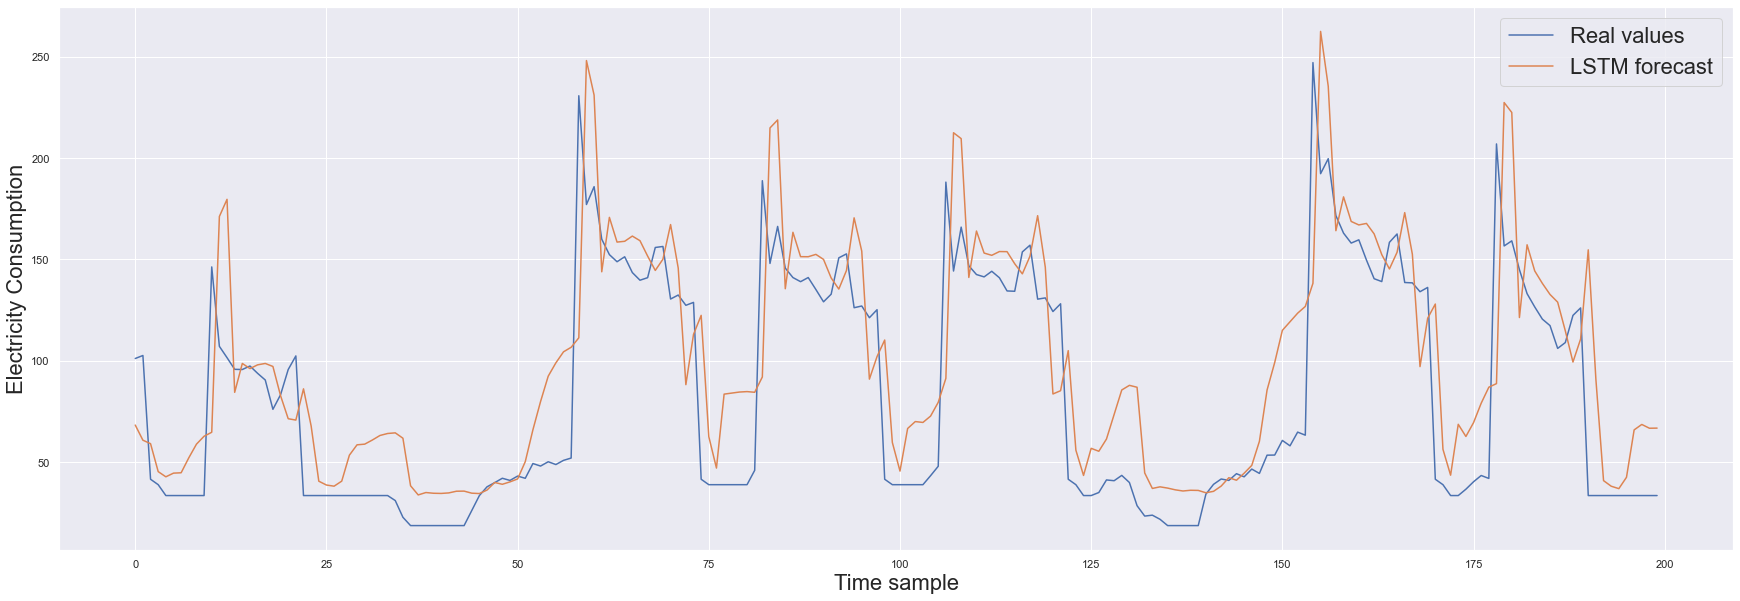

In [114]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[500:700], label='Real values')
ax.plot(LSTM_forecast[500:700], label='LSTM forecast')
ax.legend(prop={'size':22})
plt.show()

In [115]:
tf.keras.backend.clear_session()

cnn_lr = tf.keras.models.Sequential([ Conv1D(filters=50, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lr.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
93/93 [==============================] - 0s 2ms/step - loss: 0.0317 - root_mean_squared_error: 0.1631 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1284
Epoch 2/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 3/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0142 - root_mean_squared_error: 0.1191 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0908
Epoch 4/50
93/93 [==============================] - 0s 2ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0784
Epoch 5/50
93/93 [==============================] - 0s 2ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 6/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0052 - val_root_mean_sq

Epoch 49/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0355 - root_mean_squared_error: 0.1885 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1742
Epoch 50/50
93/93 [==============================] - 0s 1ms/step - loss: 0.0355 - root_mean_squared_error: 0.1884 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1700


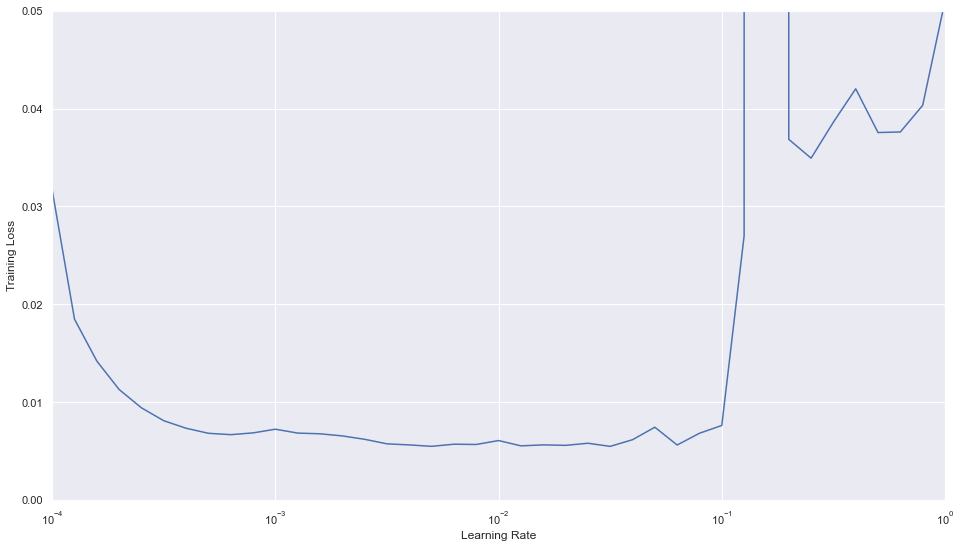

In [116]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [117]:
CNN = tf.keras.models.Sequential([Conv1D(filters = 75, kernel_size = 2, strides = 1, padding = 'causal',
                                         activation = 'relu', input_shape = input_shape),
                                  Flatten(),
                                  Dense(30, activation='relu'),
                                  Dense(1),
                                 ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_Model = CNN.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0421 - root_mean_squared_error: 0.1993 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1334
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0225 - root_mean_squared_error: 0.1499 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0784
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0058 - val_root_m

Epoch 49/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605
Epoch 50/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 51/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 52/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 53/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 54/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0036 - val_

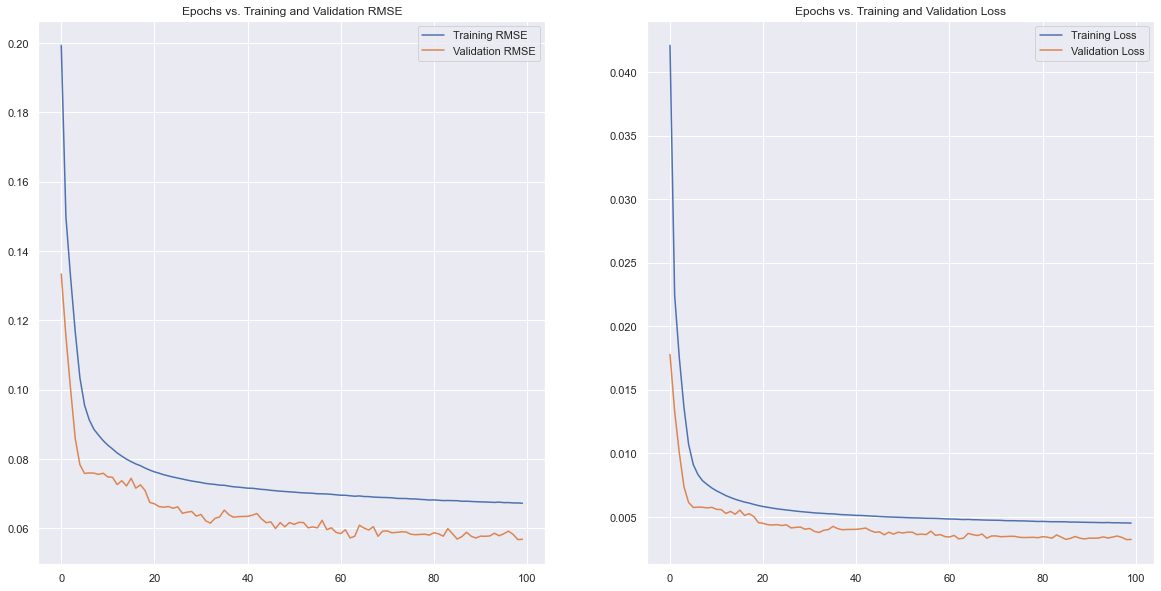

In [118]:
plot_model_rmse_and_loss(CNN_Model)

In [119]:
forecast =  CNN.predict(X_test)
CNN_forecast = scaler.inverse_transform(forecast)

rmse_CNN = sqrt(mean_squared_error(y_test_inv, CNN_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}' .format(round(rmse_CNN, 3)))

RMSE of hour-ahead electricity price multivariate CNN forecast: 33.446


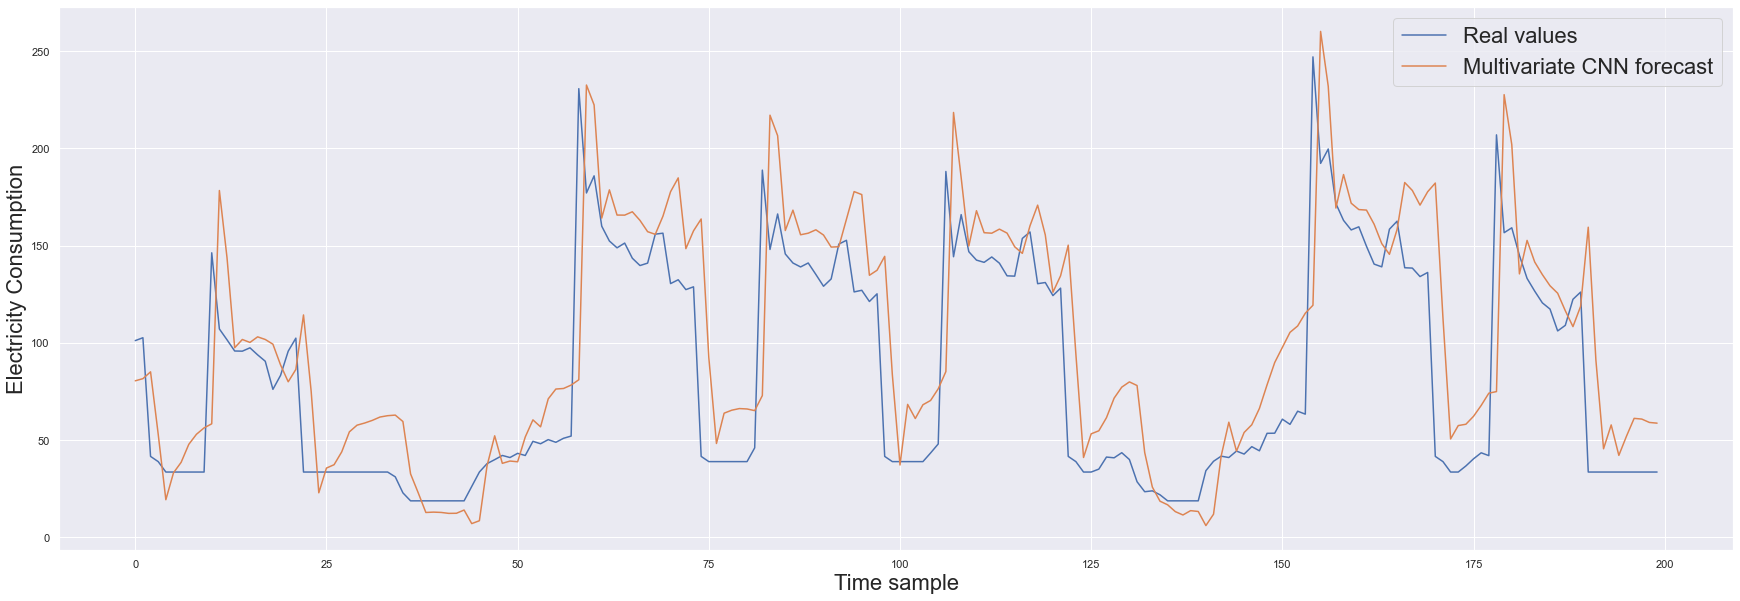

In [120]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[500:700], label='Real values')
ax.plot(CNN_forecast[500:700], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()

In [123]:
tf.keras.backend.clear_session()

cnn_lstm = tf.keras.models.Sequential([ Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lstm.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
93/93 [==============================] - 1s 13ms/step - loss: 0.0368 - root_mean_squared_error: 0.1753 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 2/50
93/93 [==============================] - 1s 7ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 3/50
93/93 [==============================] - 1s 8ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 4/50
93/93 [==============================] - 0s 5ms/step - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0718
Epoch 5/50
93/93 [==============================] - 1s 5ms/step - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 6/50
93/93 [==============================] - 1s 8ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0077 - val_root_mean_s

Epoch 49/50
93/93 [==============================] - 1s 6ms/step - loss: 0.2785 - root_mean_squared_error: 0.5277 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1838
Epoch 50/50
93/93 [==============================] - 0s 5ms/step - loss: 0.2902 - root_mean_squared_error: 0.5387 - val_loss: 0.2314 - val_root_mean_squared_error: 0.4811


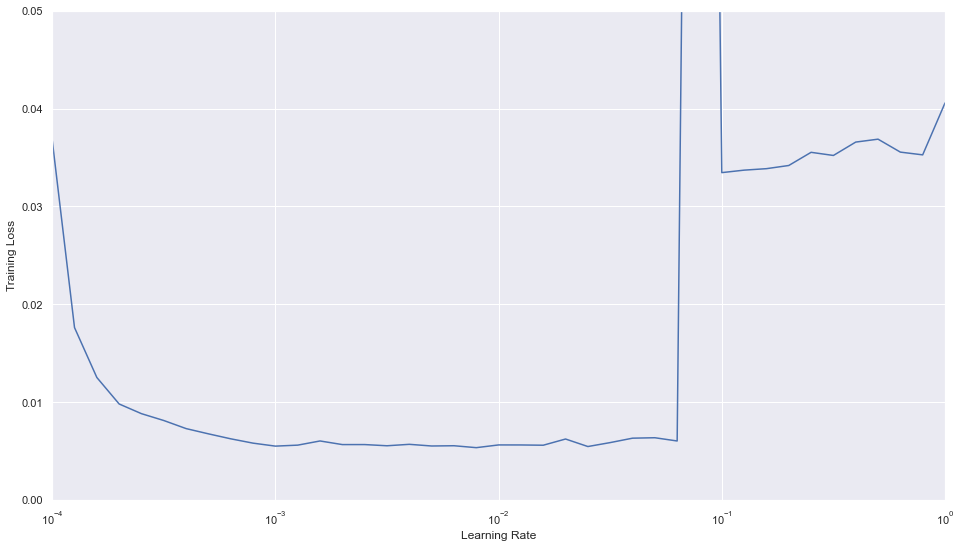

In [124]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [125]:
CNN_LSTM = tf.keras.models.Sequential([Conv1D(filters=100, kernel_size=2,strides=1, padding='causal',
                                              activation='relu', input_shape = input_shape),
                                       LSTM(50, return_sequences=True),
                                       Flatten(),
                                       Dense(30, activation='relu'),
                                       Dense(1) 
                                      ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN_LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_LSTM_Model = CNN_LSTM.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
93/93 [==============================] - 1s 8ms/step - loss: 0.0416 - root_mean_squared_error: 0.2754 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1364
Epoch 2/100
93/93 [==============================] - 0s 3ms/step - loss: 0.0225 - root_mean_squared_error: 0.1499 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1293
Epoch 3/100
93/93 [==============================] - 0s 3ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 4/100
93/93 [==============================] - 0s 3ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 5/100
93/93 [==============================] - 0s 3ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875
Epoch 6/100
93/93 [==============================] - 0s 3ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0064 - val_root_m

Epoch 49/100
93/93 [==============================] - 0s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 50/100
93/93 [==============================] - 0s 4ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 51/100
93/93 [==============================] - 0s 4ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 52/100
93/93 [==============================] - 0s 4ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 53/100
93/93 [==============================] - 0s 4ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 54/100
93/93 [==============================] - 0s 3ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0032 - val_

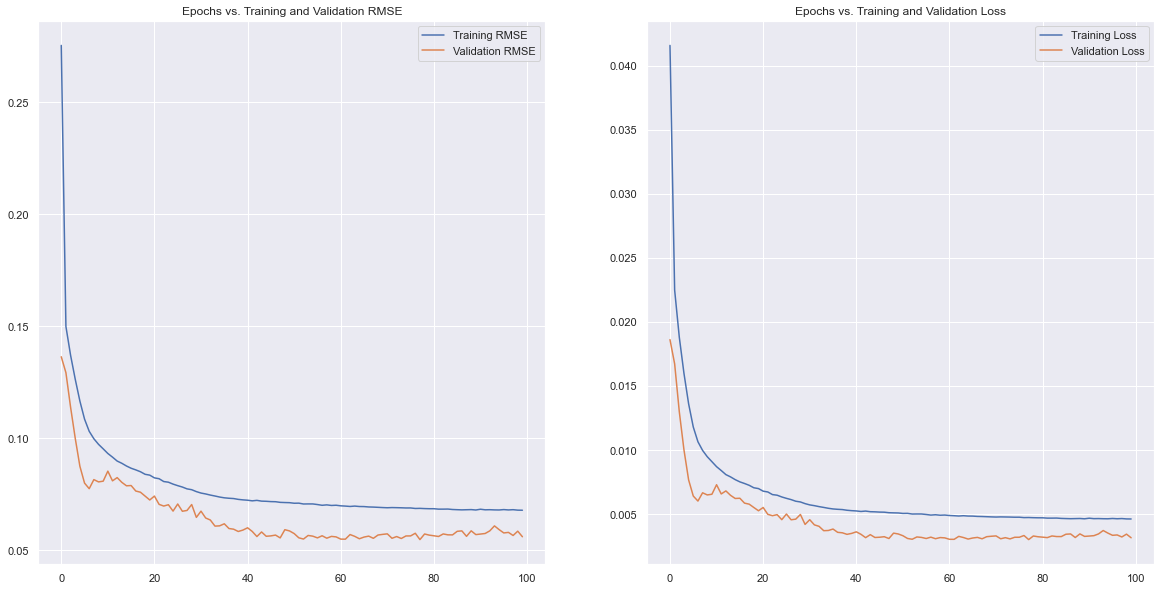

In [126]:
plot_model_rmse_and_loss(CNN_LSTM_Model)

In [127]:
forecast =  CNN_LSTM.predict(X_test)
CNN_LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv, CNN_LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: 35.038


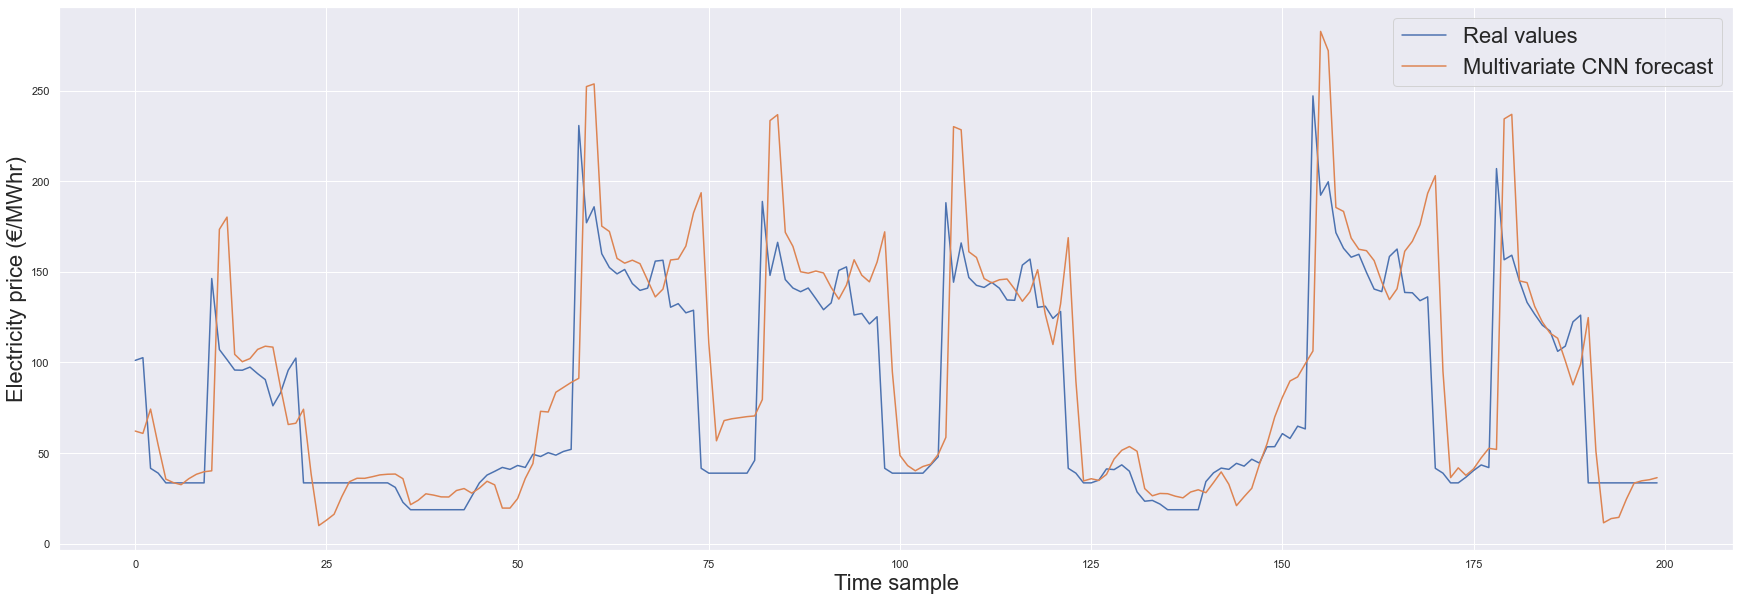

In [128]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity price (€/MWhr)', fontsize=22)
ax.plot(y_test_inv[500:700], label='Real values')
ax.plot(CNN_LSTM_forecast[500:700], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()